In [1]:
import os
import glob

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

import umap
import sys
sys.path.append('../custom_function')
import clustering # custom function

import hdbscan

random_seed = 2022
klist = [3,4,5,6,7]

import plotly.express as px
import plotly

from sklearn.manifold import TSNE

In [2]:
def neigh_dist(dissim):
    """UMAP"""
    neighbors = [5,10,15,20,25,30]
    dists = [0.001, 0.01,0.1]
    ### 1.UMAP results
    umaps_results = pd.DataFrame(columns=['neighbor','distance','Dim1','Dim2'])
    for n in neighbors:
        for d in dists:
            temp_umap = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2,
                                  random_state=random_seed,metric='precomputed').fit_transform(dissim)
            temp_umap = pd.DataFrame(temp_umap, columns=['Dim1','Dim2'])
            temp_umap['neighbor'] = n
            temp_umap['distance'] = d
            umaps_results = umaps_results.append(temp_umap, sort=True,ignore_index=True)
    
    ### 2.Plot results            
    fig, axes = plt.subplots(3,6,figsize=(18,9),sharex=True,sharey=True)
    for row in range(3): # dists
        for col in range(6): # neighbors
            ax = axes[row,col]
            min_dist = dists[row]
            n_neighbors = neighbors[col]

            x = umaps_results.loc[(umaps_results.distance==min_dist)&
                                  (umaps_results.neighbor==n_neighbors),'Dim1']
            y = umaps_results.loc[(umaps_results.distance==min_dist)&
                                  (umaps_results.neighbor==n_neighbors),'Dim2']
            ax.scatter(x,y,s=25)
            ax.set_xlabel(f'minimum distance:{min_dist}')
            ax.set_ylabel(f'nearest neighbor:{n_neighbors}')

    plt.tight_layout()
    plt.show()
    return(umaps_results)

In [3]:
def cluster_results(result_df, method_number='cl_k5'):
    for n in range(len(result_df[method_number].unique())):
        each_cluster = result_df.index[result_df[method_number]==n]
        print("\nCluster "+str(n+1)+" Relationship:{}".format(len(each_cluster)))
        print(*result_df.index[result_df[method_number]==n], sep = ", ")

# Import data

In [4]:
input_dir = '../output_data/group/category/'
# all 59 participants
dissim_ctg_avg_159r_all = pd.read_csv(input_dir + 'dissim_ctg_avg_159rel_all_59p.csv',index_col=0)
dissim_mla_avg_159r_all = pd.read_csv(input_dir + 'dissim_mla_avg_159rel_all_59p.csv',index_col=0)

We use UMAP as a dimensionality reduction technique that generalizes to nonlinearities, and KMeans to clustering analysis

# Explicit task(M2)

## t-sne: perplexity

In [45]:
resultdf_tsne = pd.DataFrame({'perplex':[], 'clusterCount':[], 'silhouette':[]})
for perplex in range(5,55,5):
    df_subset = TSNE(n_components=2, perplexity=perplex, random_state=random_seed).\
                fit_transform(dissim_ctg_avg_159r_all)
    for k in range(2,8):
        model = KMeans(k, random_state=random_seed)
        model.fit(df_subset)
        cluster_labels = model.fit_predict(df_subset)
        silhouette_avg = silhouette_score(df_subset, cluster_labels)

        resultdf_tsne = resultdf_tsne.append({'perplex':perplex,'clusterCount':k,
                         'silhouette':silhouette_avg},ignore_index=True)  

## minimum distance&nearest neighbor

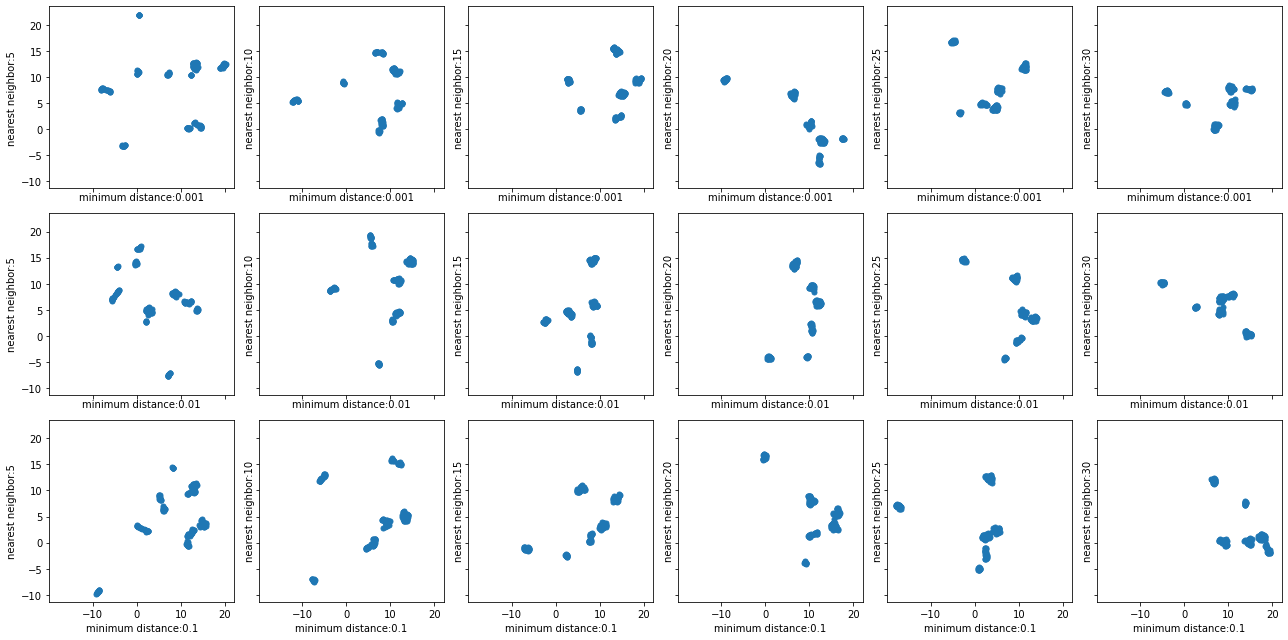

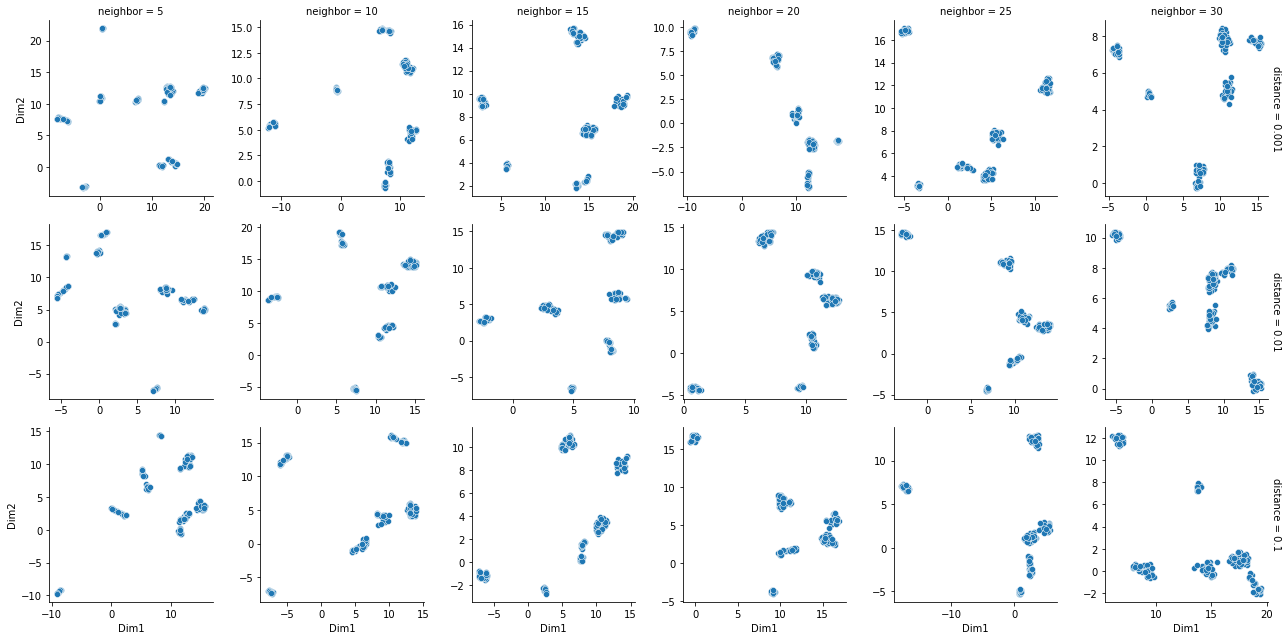

In [6]:
ctg_umaps_results = neigh_dist(dissim = dissim_ctg_avg_159r_all)
g = sns.FacetGrid(ctg_umaps_results, row='distance', col='neighbor',
                  margin_titles=True, sharex=False, sharey=False)
g.map(sns.scatterplot, 'Dim1', 'Dim2')

In [7]:
resultdf = pd.DataFrame({'dist':[],'ngbr':[], 'clusterCount':[], 'silhouette':[]})
for dist in [0.001, 0.01,0.1]:
    for ngbr in [5,10,15,20,25,30]:
        df_subset = ctg_umaps_results[(ctg_umaps_results['distance']==dist) & \
                                      (ctg_umaps_results['neighbor']==ngbr)].iloc[:,:2]
        for k in range(2,8):
            model = KMeans(k, random_state=random_seed)
            model.fit(df_subset)
            cluster_labels = model.fit_predict(df_subset)
            silhouette_avg = silhouette_score(df_subset, cluster_labels)
            
            resultdf = resultdf.append({'dist':dist,'ngbr':ngbr,'clusterCount':k,
                             'silhouette':silhouette_avg},ignore_index=True)  

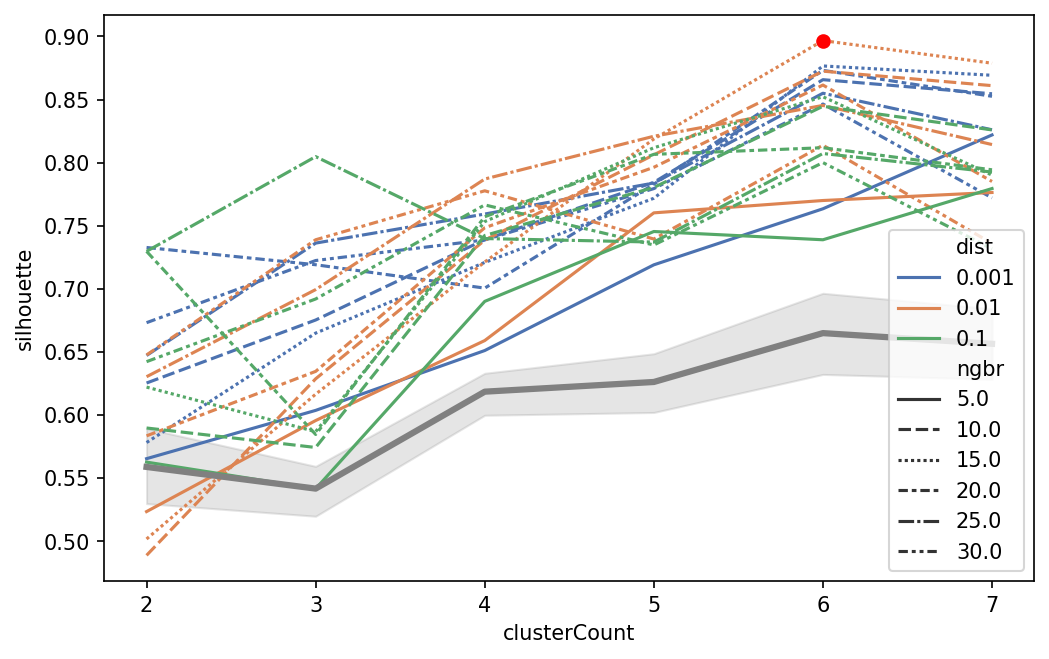

In [8]:
plt.figure(figsize = (8,5),dpi=150)
sns.lineplot(data=resultdf, x='clusterCount', y='silhouette',hue='dist',style='ngbr',palette="deep")
sns.lineplot(data=resultdf_tsne, x='clusterCount', y='silhouette',linewidth = 3,color="grey")
max_idx = resultdf['silhouette'].idxmax()
plt.plot(resultdf.loc[max_idx, 'clusterCount'], resultdf.loc[max_idx, 'silhouette'], marker='o', color='red')
plt.legend(loc='lower right')

<AxesSubplot:xlabel='clusterCount', ylabel='silhouette'>

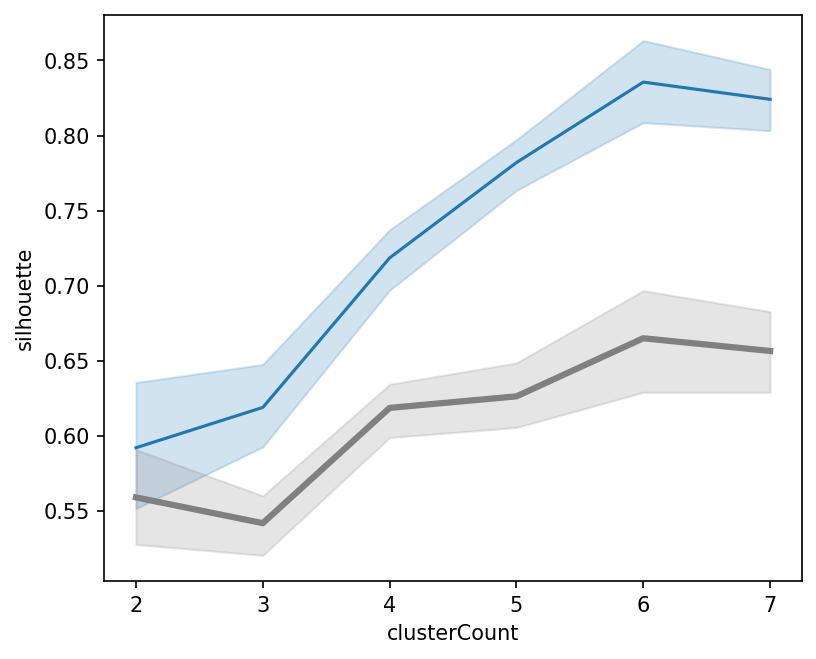

In [46]:
dists = [0.001, 0.01,0.1]
neighbors = [5,10,15,20]
dissim = dissim_ctg_avg_159r_all
### 1.UMAP results
umaps_results = pd.DataFrame(columns=['neighbor','distance','Dim1','Dim2'])
for n in neighbors:
    for d in dists:
        temp_umap = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2,
                              random_state=random_seed,metric='precomputed').fit_transform(dissim)
        temp_umap = pd.DataFrame(temp_umap, columns=['Dim1','Dim2'])
        temp_umap['neighbor'] = n
        temp_umap['distance'] = d
        umaps_results = umaps_results.append(temp_umap, sort=True,ignore_index=True)
        
mla_umaps_results = umaps_results       
resultdf = pd.DataFrame({'dist':[],'ngbr':[], 'clusterCount':[], 'silhouette':[]})
for dist in dists:
    for ngbr in neighbors:
        df_subset = mla_umaps_results[(mla_umaps_results['distance']==dist) & \
                                      (mla_umaps_results['neighbor']==ngbr)].iloc[:,:2]
        for k in range(2,8):
            model = KMeans(k, random_state=random_seed)
            model.fit(df_subset)
            cluster_labels = model.fit_predict(df_subset)
            silhouette_avg = silhouette_score(df_subset, cluster_labels)
            
            resultdf = resultdf.append({'dist':dist,'ngbr':ngbr,'clusterCount':k,
                             'silhouette':silhouette_avg},ignore_index=True) 
            
plt.figure(figsize = (6,5),dpi=150)
sns.lineplot(data=resultdf, x='clusterCount', y='silhouette')
sns.lineplot(data=resultdf_tsne, x='clusterCount', y='silhouette',linewidth = 3,color="grey")

## UMAP+KMeans

In [9]:
umap_exp_159r_all = umap.UMAP(n_neighbors=15, min_dist=0.01, n_components=2,
                      metric = 'precomputed',
                      random_state=random_seed).fit_transform(dissim_ctg_avg_159r_all)

umap_exp_159r_all = pd.DataFrame(umap_exp_159r_all, columns=['Dim1','Dim2'], index=dissim_ctg_avg_159r_all.index)

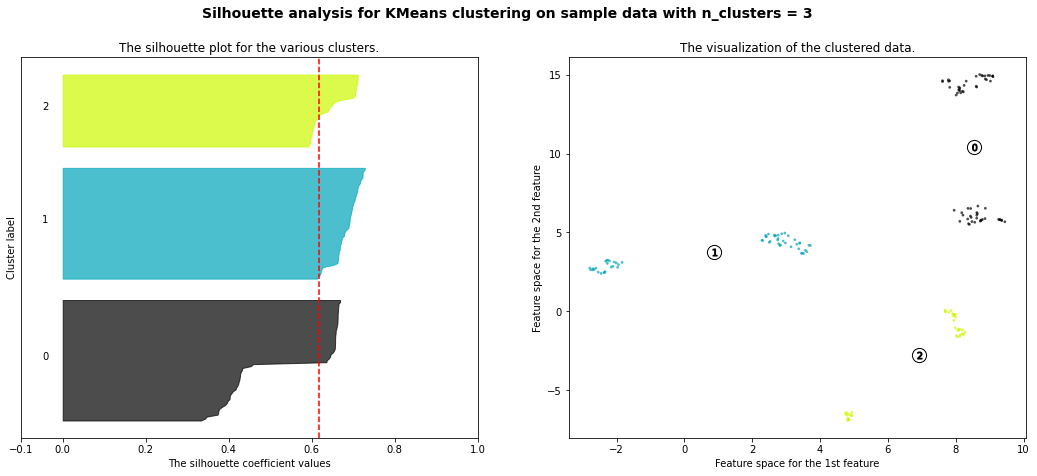

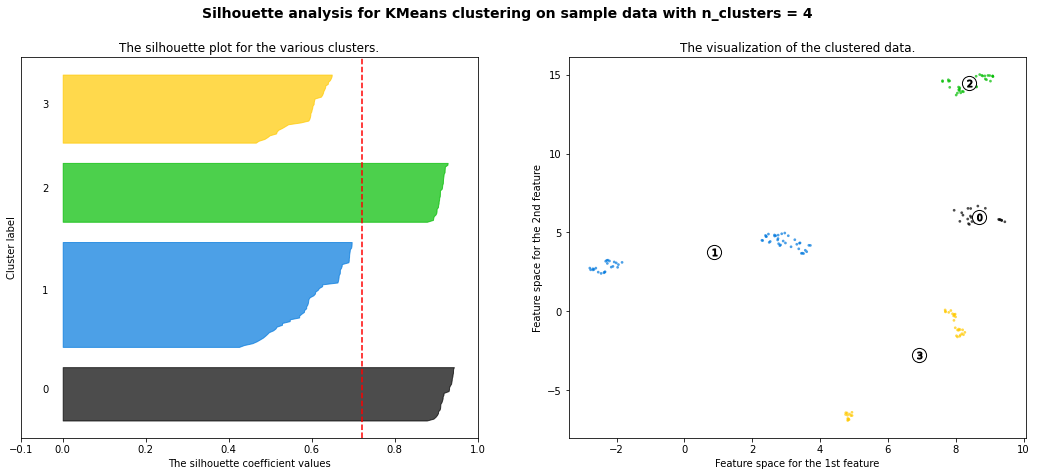

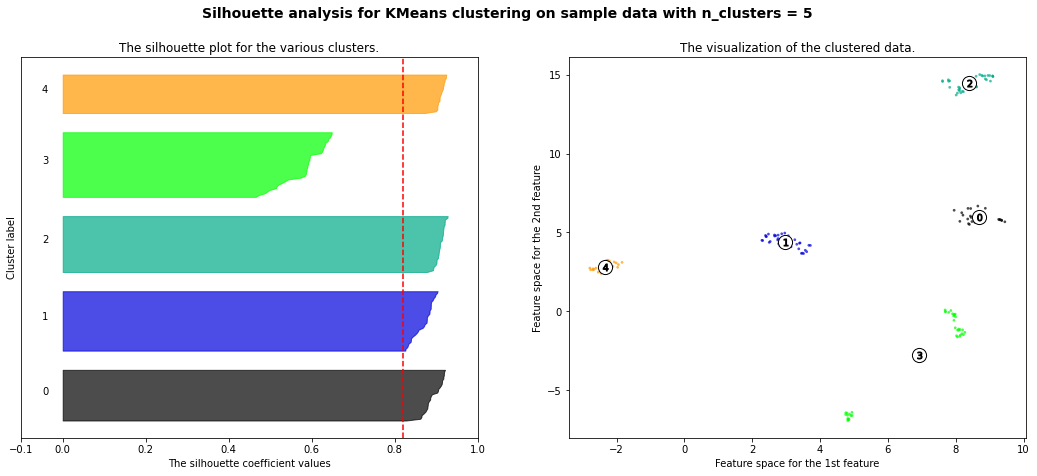

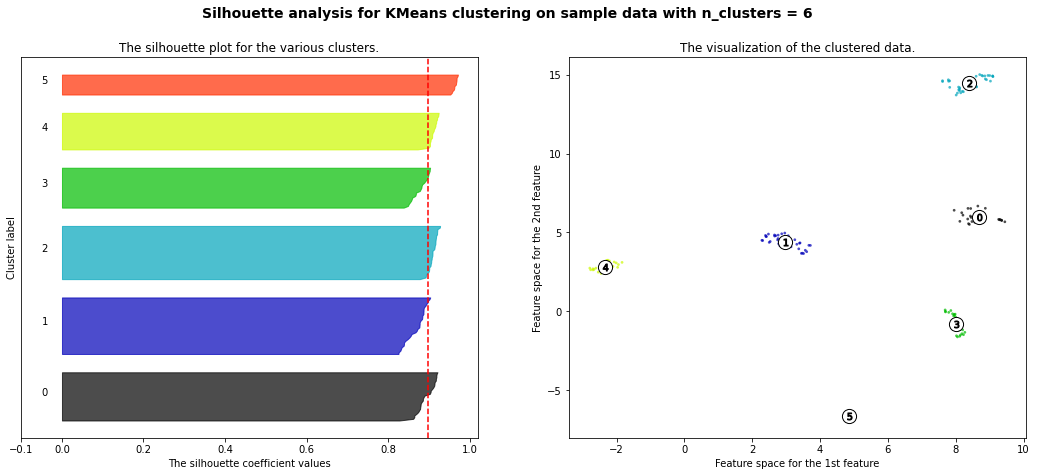

In [10]:
clustering.silhouette_cluster(umap_exp_159r_all, *[3,4,5,6])

In [5]:
# 7 clusters doesn't result in another meaningful cluster
# clustering.cluster_results(umap_exp_results_159r_all,method_number='cl_k7')

In [11]:
umap_exp_results_159r_all = clustering.create_cluster_models(data_type = "df",data =umap_exp_159r_all,
                                                  methods= ['KMeans', 'Hierarchical'],ks=  [2]+klist, keep_orig=True)
clustering.cluster_results(umap_exp_results_159r_all,method_number='cl_k3')


Cluster 1 Relationship:63
nurse and patient, doctor and patient, prostitute and customer, landlord and tenant, representative and citizen, television host and guest, guest and host, neighbors, dealer and buyer, friends, teammates in sports, patient and caretaker, therapist and patient, brothers in arms, driver and passenger, native and tourist, co workers, bride and bridesmaid, alumni, classmates, psychologist and client, reader and writer, church members, roommates, customer and businessman, victim and witness, politician and supporter, drug dealer and addict, close friends, salesperson and customer, confidants, playmates, guide and tourist, fraternity brothers, a person and their family friends, groom and groomsman, strangers, chef and customer, business partners, peers, performer and audience, celebrity and fans, cohabitants, pen friends, judge and contestant, casual acquaintances, diplomats, facebook friends, companions, reviewer and writer, lawyer and client, consultant and clien

In [12]:
clustering.cluster_results(umap_exp_results_159r_all,method_number='cl_k4')


Cluster 1 Relationship:30
nurse and patient, doctor and patient, prostitute and customer, landlord and tenant, representative and citizen, television host and guest, guest and host, dealer and buyer, patient and caretaker, therapist and patient, driver and passenger, native and tourist, psychologist and client, reader and writer, customer and businessman, politician and supporter, drug dealer and addict, salesperson and customer, guide and tourist, chef and customer, performer and audience, celebrity and fans, judge and contestant, reviewer and writer, lawyer and client, consultant and client, researcher and research subject, babysitter and infant, entrepreneur and investor, customer and server

Cluster 2 Relationship:58
parent and infant, volunteer and organizer, distant relatives, ancestor and descendant, judge and lawyer, officer and soldier, godparent and godchild, step parent and step child, employer and employee, university student and administrator, athletic trainer and trainee

In [13]:
clustering.cluster_results(umap_exp_results_159r_all,method_number='cl_k5')


Cluster 1 Relationship:30
nurse and patient, doctor and patient, prostitute and customer, landlord and tenant, representative and citizen, television host and guest, guest and host, dealer and buyer, patient and caretaker, therapist and patient, driver and passenger, native and tourist, psychologist and client, reader and writer, customer and businessman, politician and supporter, drug dealer and addict, salesperson and customer, guide and tourist, chef and customer, performer and audience, celebrity and fans, judge and contestant, reviewer and writer, lawyer and client, consultant and client, researcher and research subject, babysitter and infant, entrepreneur and investor, customer and server

Cluster 2 Relationship:35
volunteer and organizer, judge and lawyer, officer and soldier, employer and employee, university student and administrator, athletic trainer and trainee, predecessor and successor, mentor and mentee, superior and subordinate, leader and follower, union leader and uni

### six clusters

In [14]:
clustering.cluster_results(umap_exp_results_159r_all,method_number='cl_k6')


Cluster 1 Relationship:30
nurse and patient, doctor and patient, prostitute and customer, landlord and tenant, representative and citizen, television host and guest, guest and host, dealer and buyer, patient and caretaker, therapist and patient, driver and passenger, native and tourist, psychologist and client, reader and writer, customer and businessman, politician and supporter, drug dealer and addict, salesperson and customer, guide and tourist, chef and customer, performer and audience, celebrity and fans, judge and contestant, reviewer and writer, lawyer and client, consultant and client, researcher and research subject, babysitter and infant, entrepreneur and investor, customer and server

Cluster 2 Relationship:35
volunteer and organizer, judge and lawyer, officer and soldier, employer and employee, university student and administrator, athletic trainer and trainee, predecessor and successor, mentor and mentee, superior and subordinate, leader and follower, union leader and uni

Cluster1: Transactional(30)  
Cluster2: Power(35)  
Cluster3: Affiliative(33)   
Cluster4: Hostile(25)  
Cluster5: Familial(23)    
Cluster6: Romantic(13)   

a little bit different from the first run, that is the order of clusters is different.

In [15]:
clustering.cluster_results(umap_exp_results_159r_all,method_number='cl_h6')


Cluster 1 Relationship:25
opposing negotiators, man wife and man mistress, frenemies, enemies, slave and master, romantic rivals, sports rivals, guard and prisoner, criminal and police officer, defendant and plaintiff, police officer and civilian, political opponents, competitors in sports, bully and victim, criminal and prosecutor, master and servant, business rivals, ex lovers, victim and criminal, criminal and hostage, fans of opposing sports teams, divorced spouses, parole officer and parolee, celebrity and haters, police officer and offender

Cluster 2 Relationship:33
neighbors, friends, teammates in sports, brothers in arms, co workers, bride and bridesmaid, alumni, classmates, church members, roommates, victim and witness, close friends, confidants, playmates, fraternity brothers, a person and their family friends, groom and groomsman, strangers, business partners, peers, cohabitants, pen friends, casual acquaintances, diplomats, facebook friends, companions, criminal and their

<table><tr><td bgcolor="green"><font size=5>output</font></td></tr></table>

In [32]:
# umap_exp_results_159r_all.to_csv('../output_data/group/category/cluster_results/umap_exp_results_159r_all.csv')

In [16]:
umap_exp_results_159r_all.to_csv('../output_data/group/category/cluster_results/umap_exp_results_159r_all_20230920.csv')

### HPP

In [84]:
umap_exp_159r_all_3C = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2,
                      metric = 'precomputed',
                      random_state=random_seed).fit_transform(dissim_ctg_avg_159r_all)

umap_exp_159r_all_3C = pd.DataFrame(umap_exp_159r_all_3C, columns=['Dim1','Dim2'], index=dissim_ctg_avg_159r_all.index)
umap_exp_results_159r_all_3C = clustering.create_cluster_models(data_type = "df",data =umap_exp_159r_all_3C,
                                                  methods= ['KMeans', 'Hierarchical'],ks=  [2]+klist, keep_orig=True)
clustering.cluster_results(umap_exp_results_159r_all_3C,method_number='cl_k3')


Cluster 1 Relationship:60
opposing negotiators, man wife and man mistress, volunteer and organizer, judge and lawyer, officer and soldier, frenemies, enemies, slave and master, romantic rivals, employer and employee, university student and administrator, athletic trainer and trainee, sports rivals, guard and prisoner, criminal and police officer, predecessor and successor, defendant and plaintiff, mentor and mentee, superior and subordinate, leader and follower, union leader and union member, police officer and civilian, political opponents, teacher and student, manager and staff, team captain and team members, competitors in sports, boss and secretary, bully and victim, director and performer, criminal and prosecutor, chief and deputy, master and servant, owner and manager, a monarch and their minister, business rivals, interviewer and job applicant, student and dorm resident assistant, manager and assistant, ex lovers, professor and teaching assistant, club member and club president

## Heatmap

In [17]:
rels_simple = pd.read_csv('../input_data/Rel_labels/labels_different_versions.csv',index_col=0)
rels_simple_zipped = zip(rels_simple['two'],rels_simple['common'])
rels_simple_mapped = {key:value for key,value in rels_simple_zipped}

### static(2022)

In [18]:
umap_exp_results_159r_all = pd.read_csv('../output_data/group/category/cluster_results/umap_exp_results_159r_all.csv',
                                       index_col=0)
umap_exp_results_159r_all.index = umap_exp_results_159r_all.index.map(rels_simple_mapped)

rels_c6_df = pd.DataFrame(umap_exp_results_159r_all['cl_k6'])
rels_c6_df[rels_c6_df['cl_k6'] == 5] = -6 #Hostile
rels_c6_df[rels_c6_df['cl_k6'] == 3] = -5 #Romantic
rels_c6_df[rels_c6_df['cl_k6'] == 2] = -4 #Familial
rels_c6_df[rels_c6_df['cl_k6'] == 1] = -3 #Affiliative
rels_c6_df[rels_c6_df['cl_k6'] == 4] = -2 #Transactional
rels_c6_df[rels_c6_df['cl_k6'] == 0] = -1 #Power

rels_c6_df = rels_c6_df.sort_values(by='cl_k6')
rels_c6 = list(rels_c6_df.index)
umap_exp_results_159r_all_order = umap_exp_results_159r_all.loc[rels_c6,:]

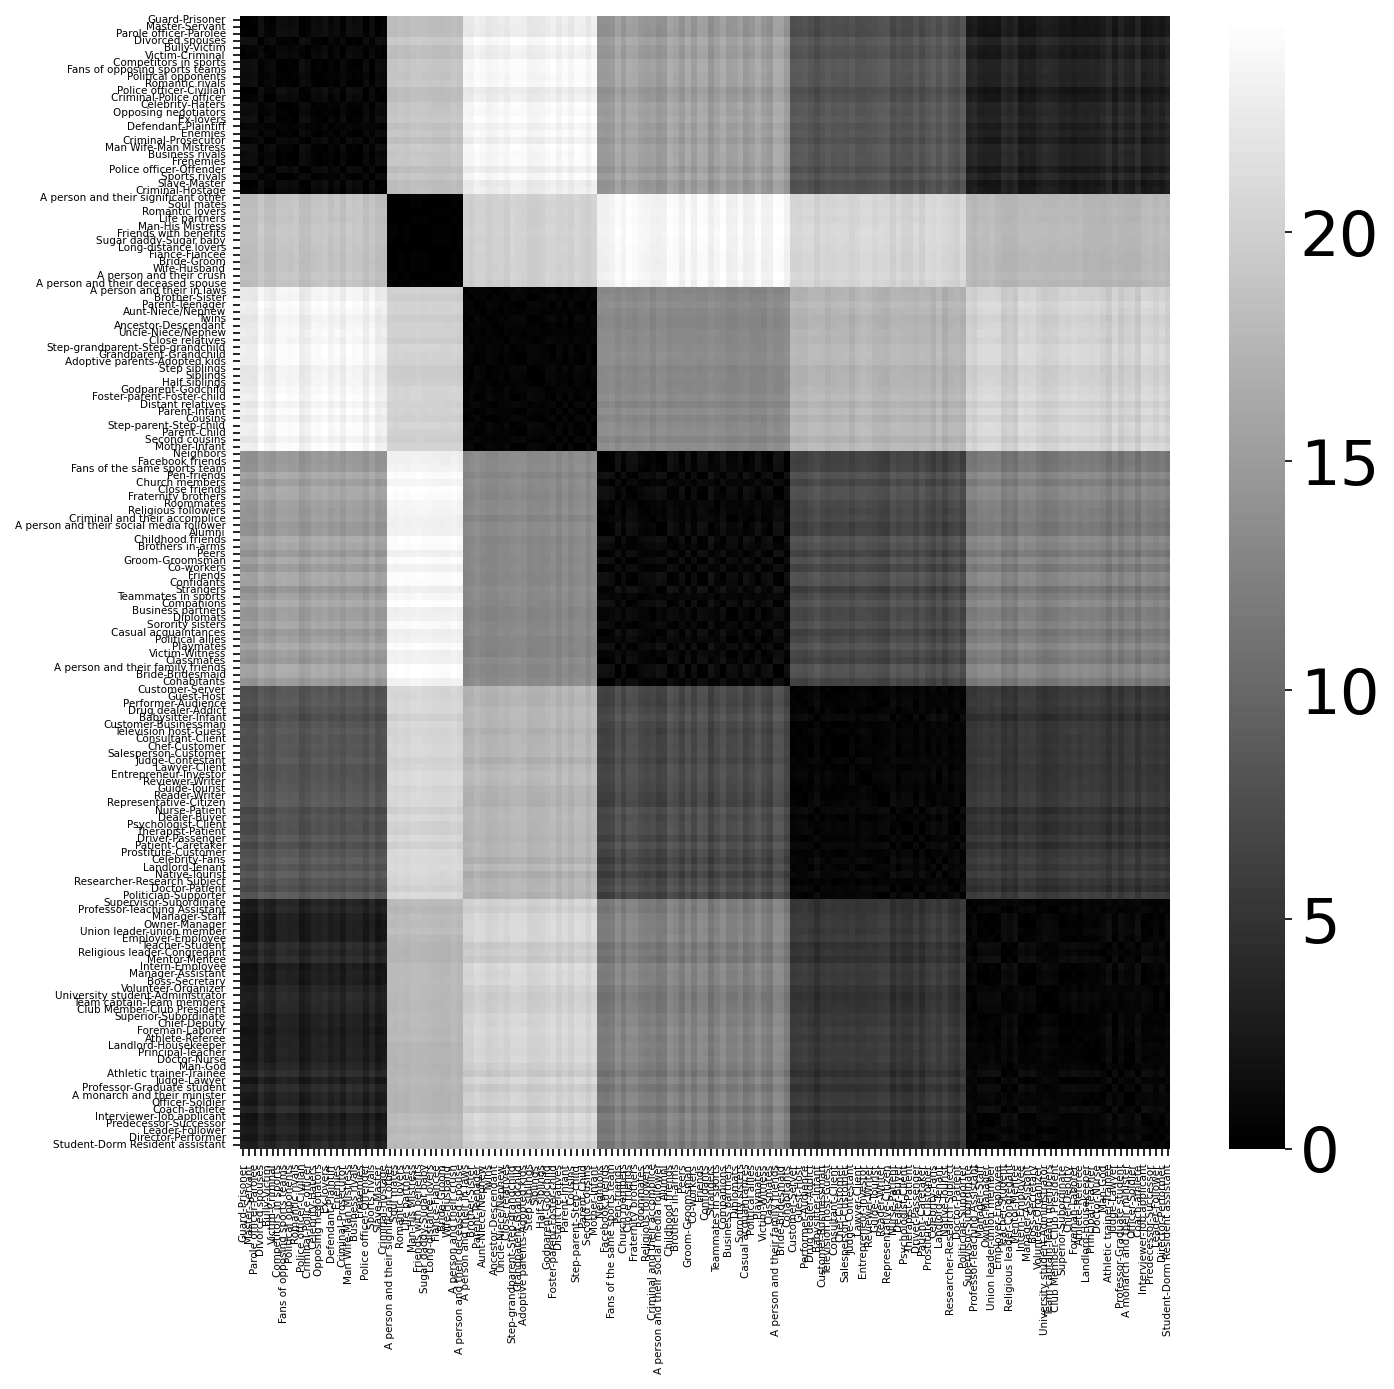

In [19]:
plt.figure(figsize=(10,10),dpi=150)
# plt.title('RDM of Explicit task (59 participants and 159 relationships)')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
mycolor = ['black','grey','white']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)

dissim_umap_rdm = euclidean_distances(umap_exp_results_159r_all_order[['Dim1','Dim2']])
ax = sns.heatmap(dissim_umap_rdm,xticklabels=rels_c6,yticklabels=rels_c6,
            cmap = cmaps)
cbar=ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

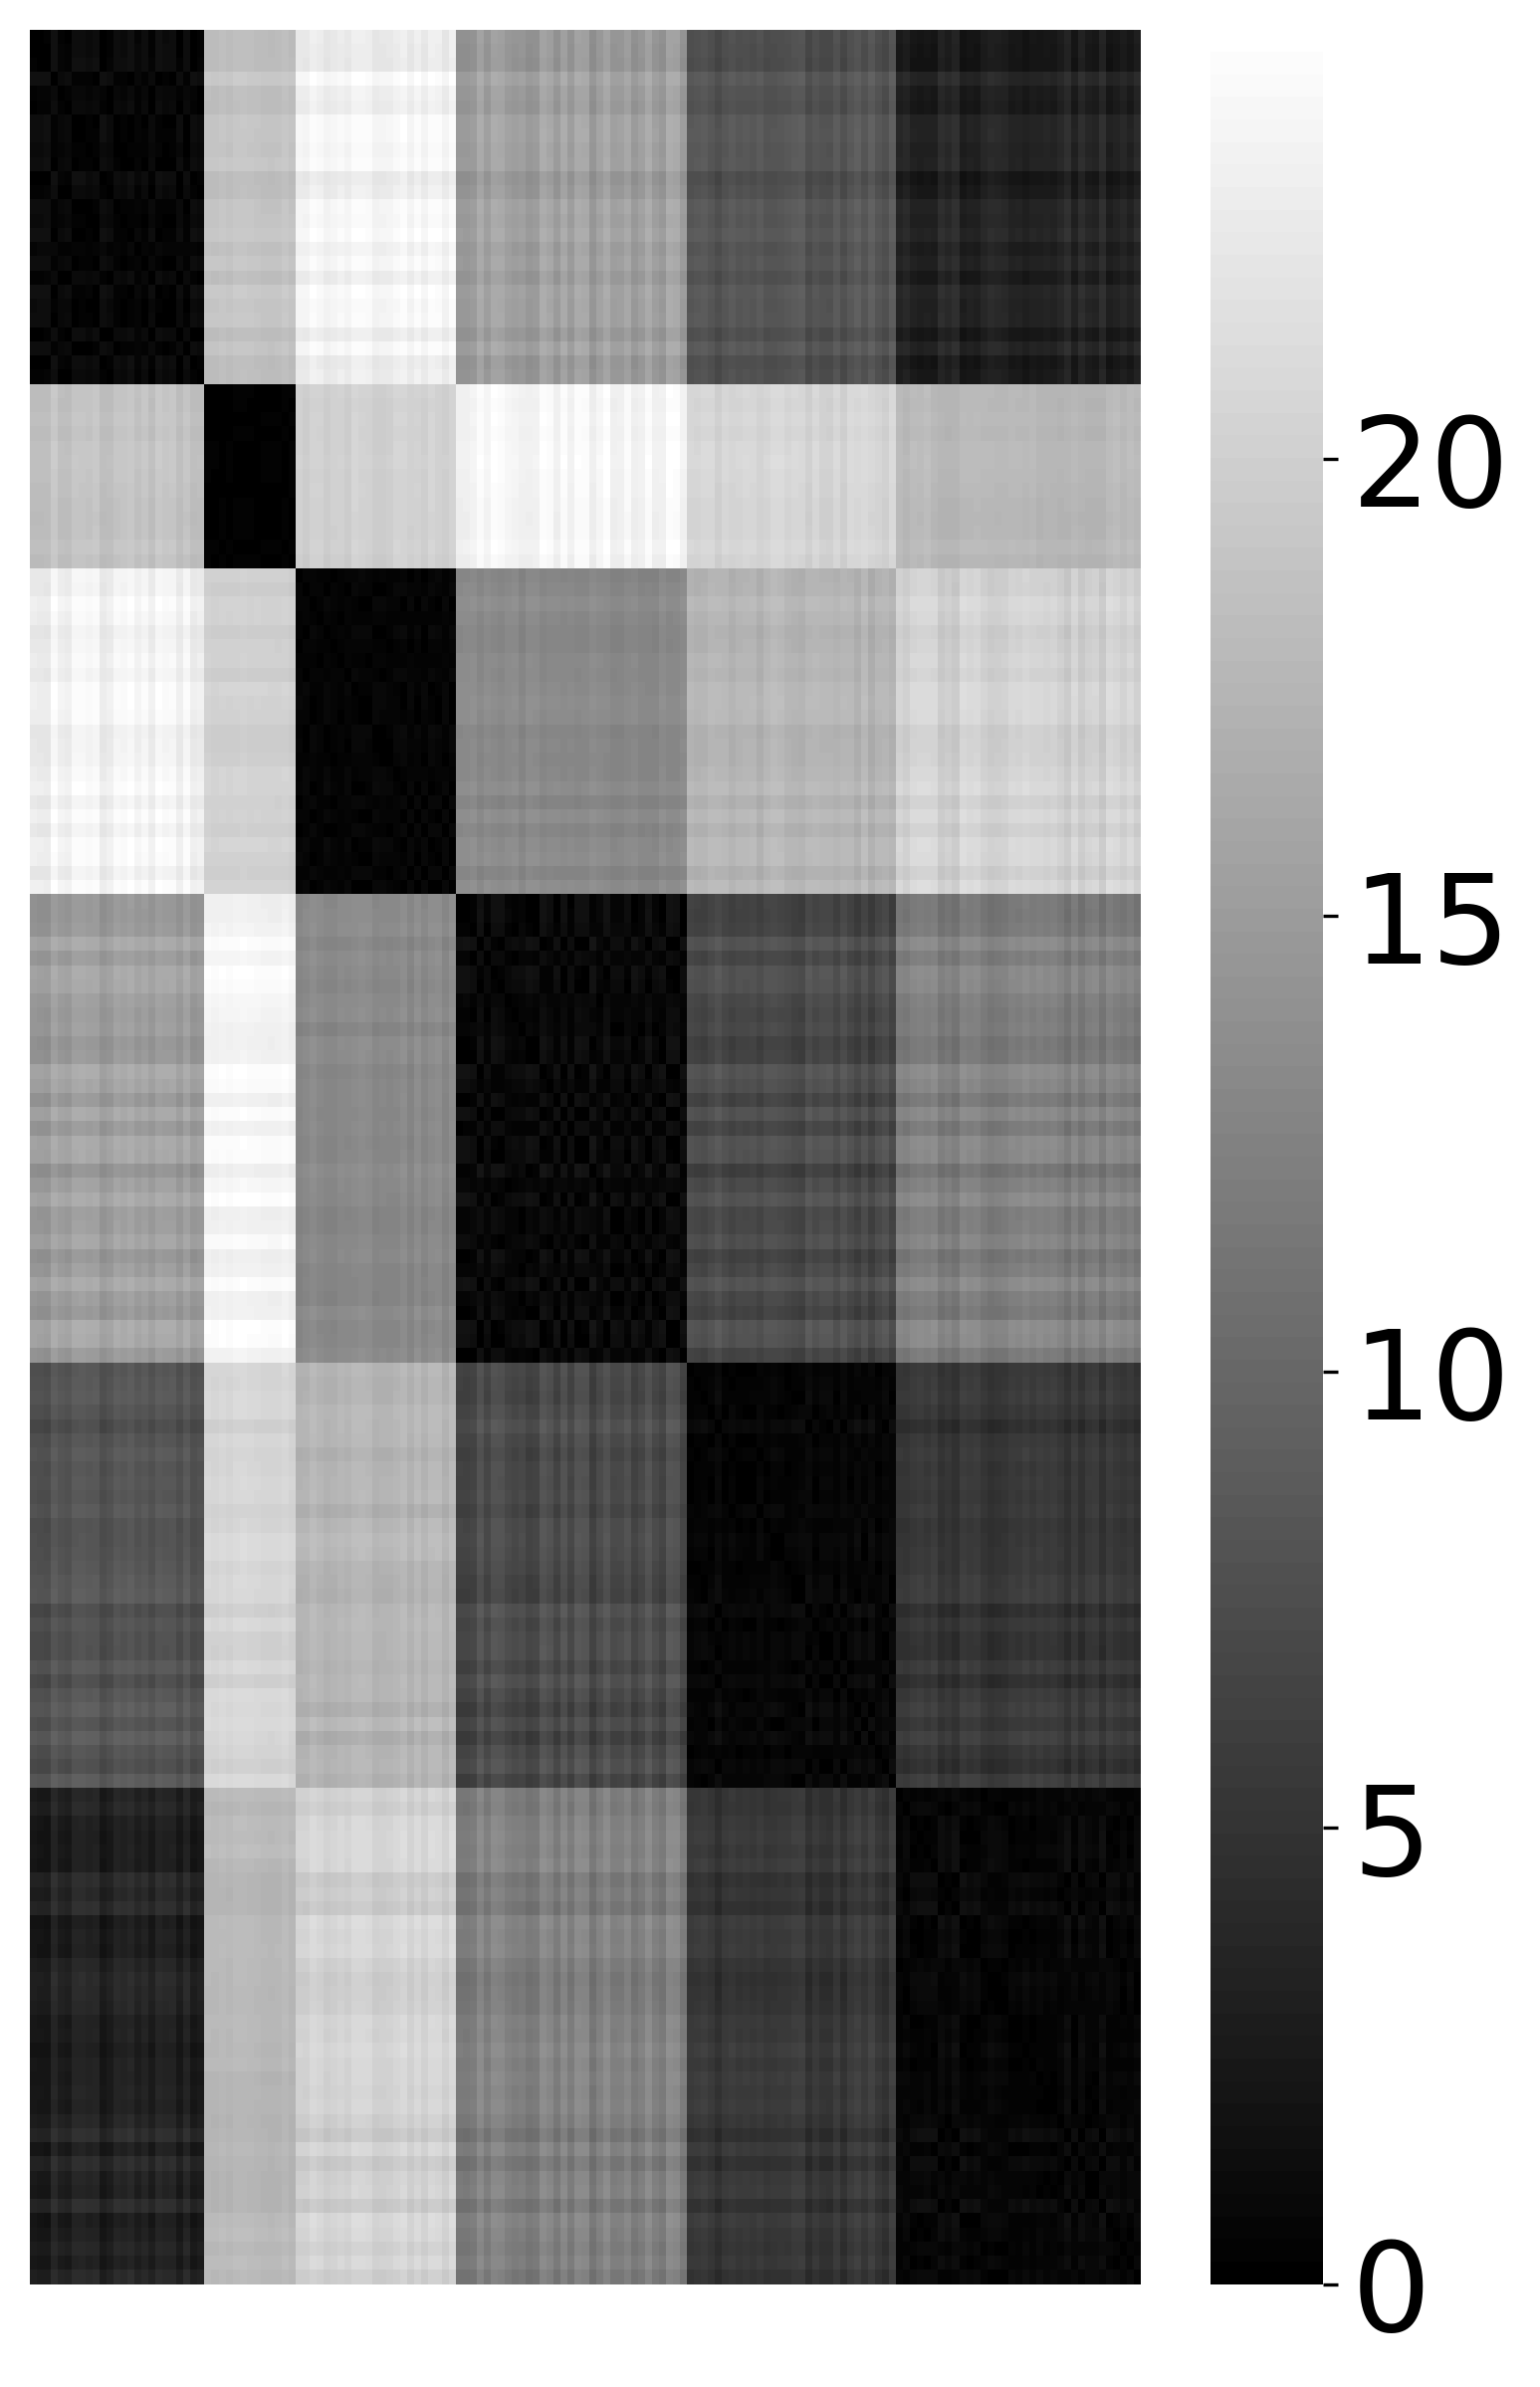

In [20]:
plt.figure(figsize=(6,10),dpi=300)
# plt.title('RDM of Explicit task (59 participants and 159 relationships)')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
mycolor = ['black','grey','white']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)

dissim_umap_rdm = euclidean_distances(umap_exp_results_159r_all_order[['Dim1','Dim2']])
ax = sns.heatmap(dissim_umap_rdm,xticklabels='',yticklabels='',
            cmap = cmaps,cbar=True)
cbar=ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

### interactive

In [22]:
# dissim_umap_rdm_interact = pd.DataFrame(dissim_umap_rdm,index=rels_c6,columns=rels_c6)
# fig = px.imshow(dissim_umap_rdm_interact,
#                width=450,height=750,aspect='auto',
#                color_continuous_scale=["black", 'white'])
# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)
# fig.update_traces(hovertemplate='%{x}<br>%{y}<br>distance: %{z:.2f}<extra></extra>')
# fig.show()

In [23]:
# plotly.offline.plot(fig,filename='../output_graph/ModelInTasks/Interactive/M2.html')

### static(2023)

In [24]:
umap_exp_results_159r_all = pd.read_csv('../output_data/group/category/cluster_results/umap_exp_results_159r_all_20230920.csv',
                                       index_col=0)
umap_exp_results_159r_all.index = umap_exp_results_159r_all.index.map(rels_simple_mapped)

rels_c6_df = pd.DataFrame(umap_exp_results_159r_all['cl_k6'])
rels_c6_df[rels_c6_df['cl_k6'] == 3] = -6 #Hostile
rels_c6_df[rels_c6_df['cl_k6'] == 5] = -5 #Romantic
rels_c6_df[rels_c6_df['cl_k6'] == 4] = -4 #Familial
rels_c6_df[rels_c6_df['cl_k6'] == 2] = -3 #Affiliative
rels_c6_df[rels_c6_df['cl_k6'] == 0] = -2 #Transactional
rels_c6_df[rels_c6_df['cl_k6'] == 1] = -1 #Power

rels_c6_df = rels_c6_df.sort_values(by='cl_k6')
rels_c6 = list(rels_c6_df.index)
umap_exp_results_159r_all_order = umap_exp_results_159r_all.loc[rels_c6,:]

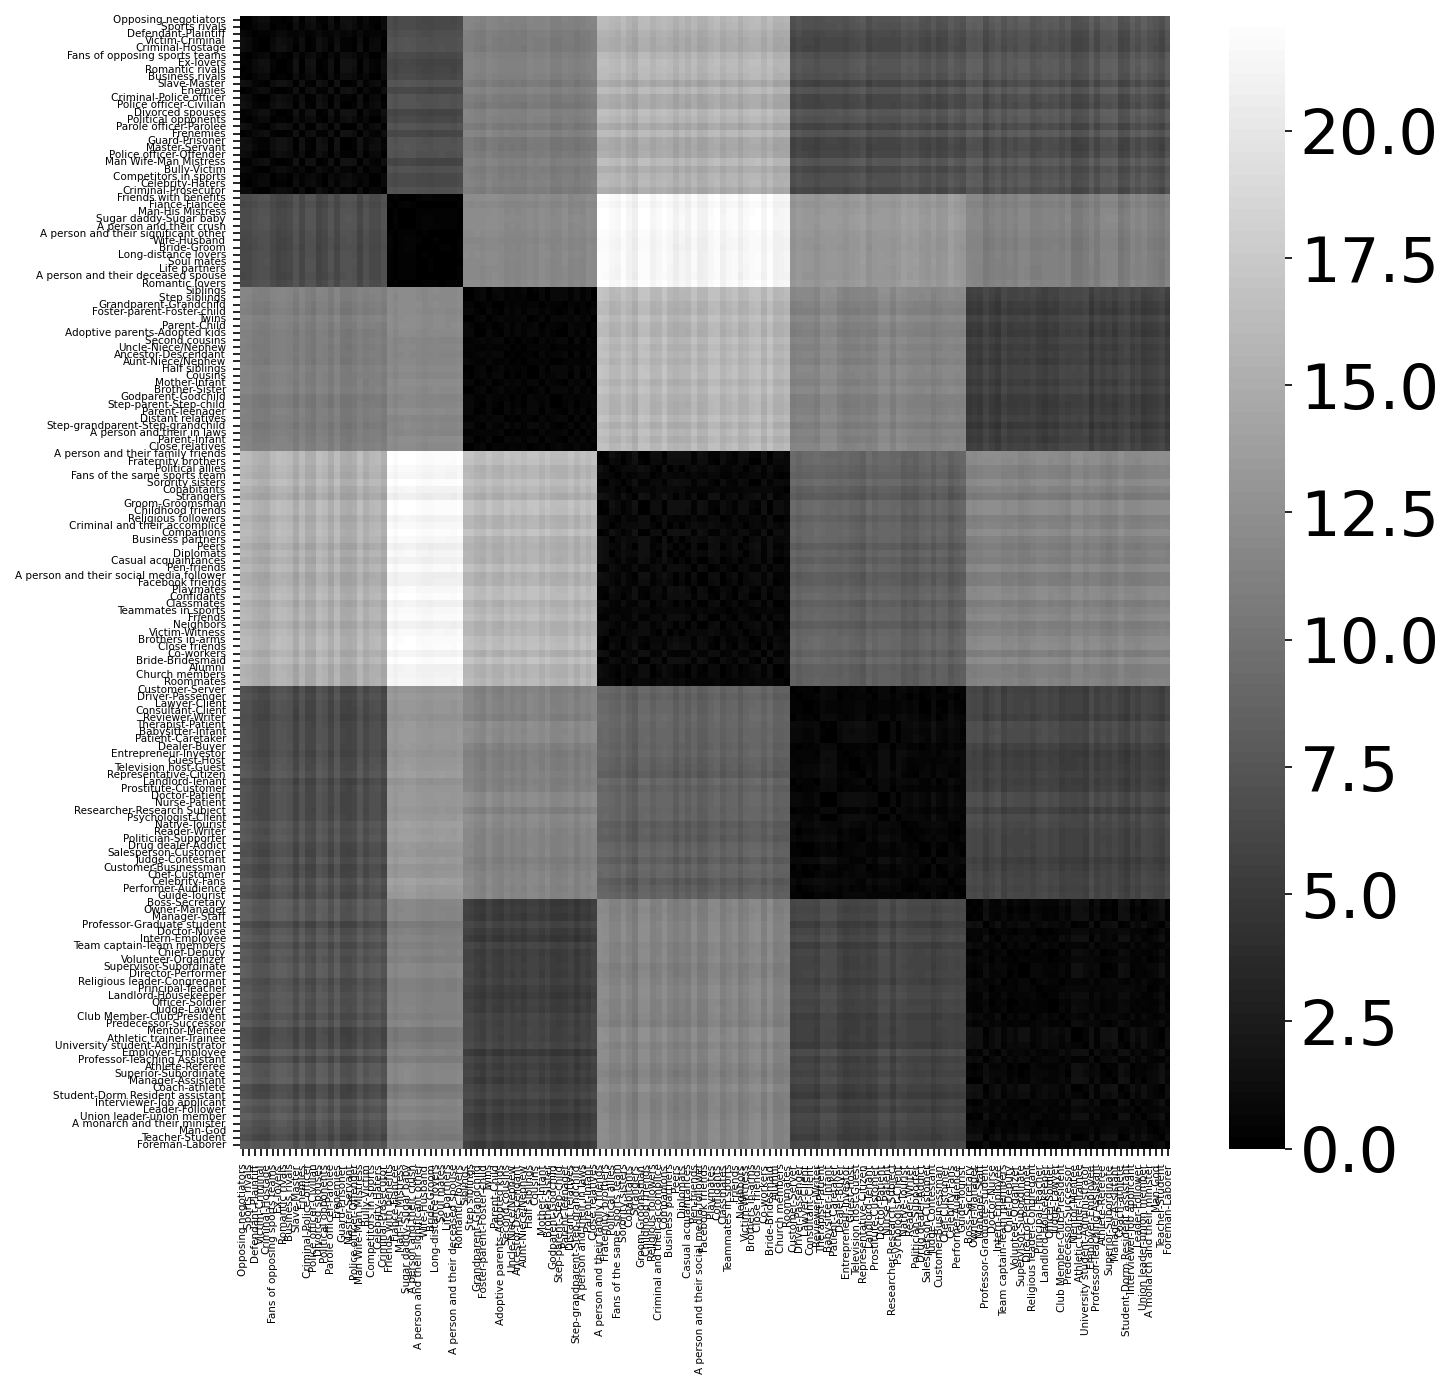

In [25]:
plt.figure(figsize=(10,10),dpi=150)
# plt.title('RDM of Explicit task (59 participants and 159 relationships)')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
mycolor = ['black','grey','white']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)

dissim_umap_rdm = euclidean_distances(umap_exp_results_159r_all_order[['Dim1','Dim2']])
ax = sns.heatmap(dissim_umap_rdm,xticklabels=rels_c6,yticklabels=rels_c6,
            cmap = cmaps)
cbar=ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

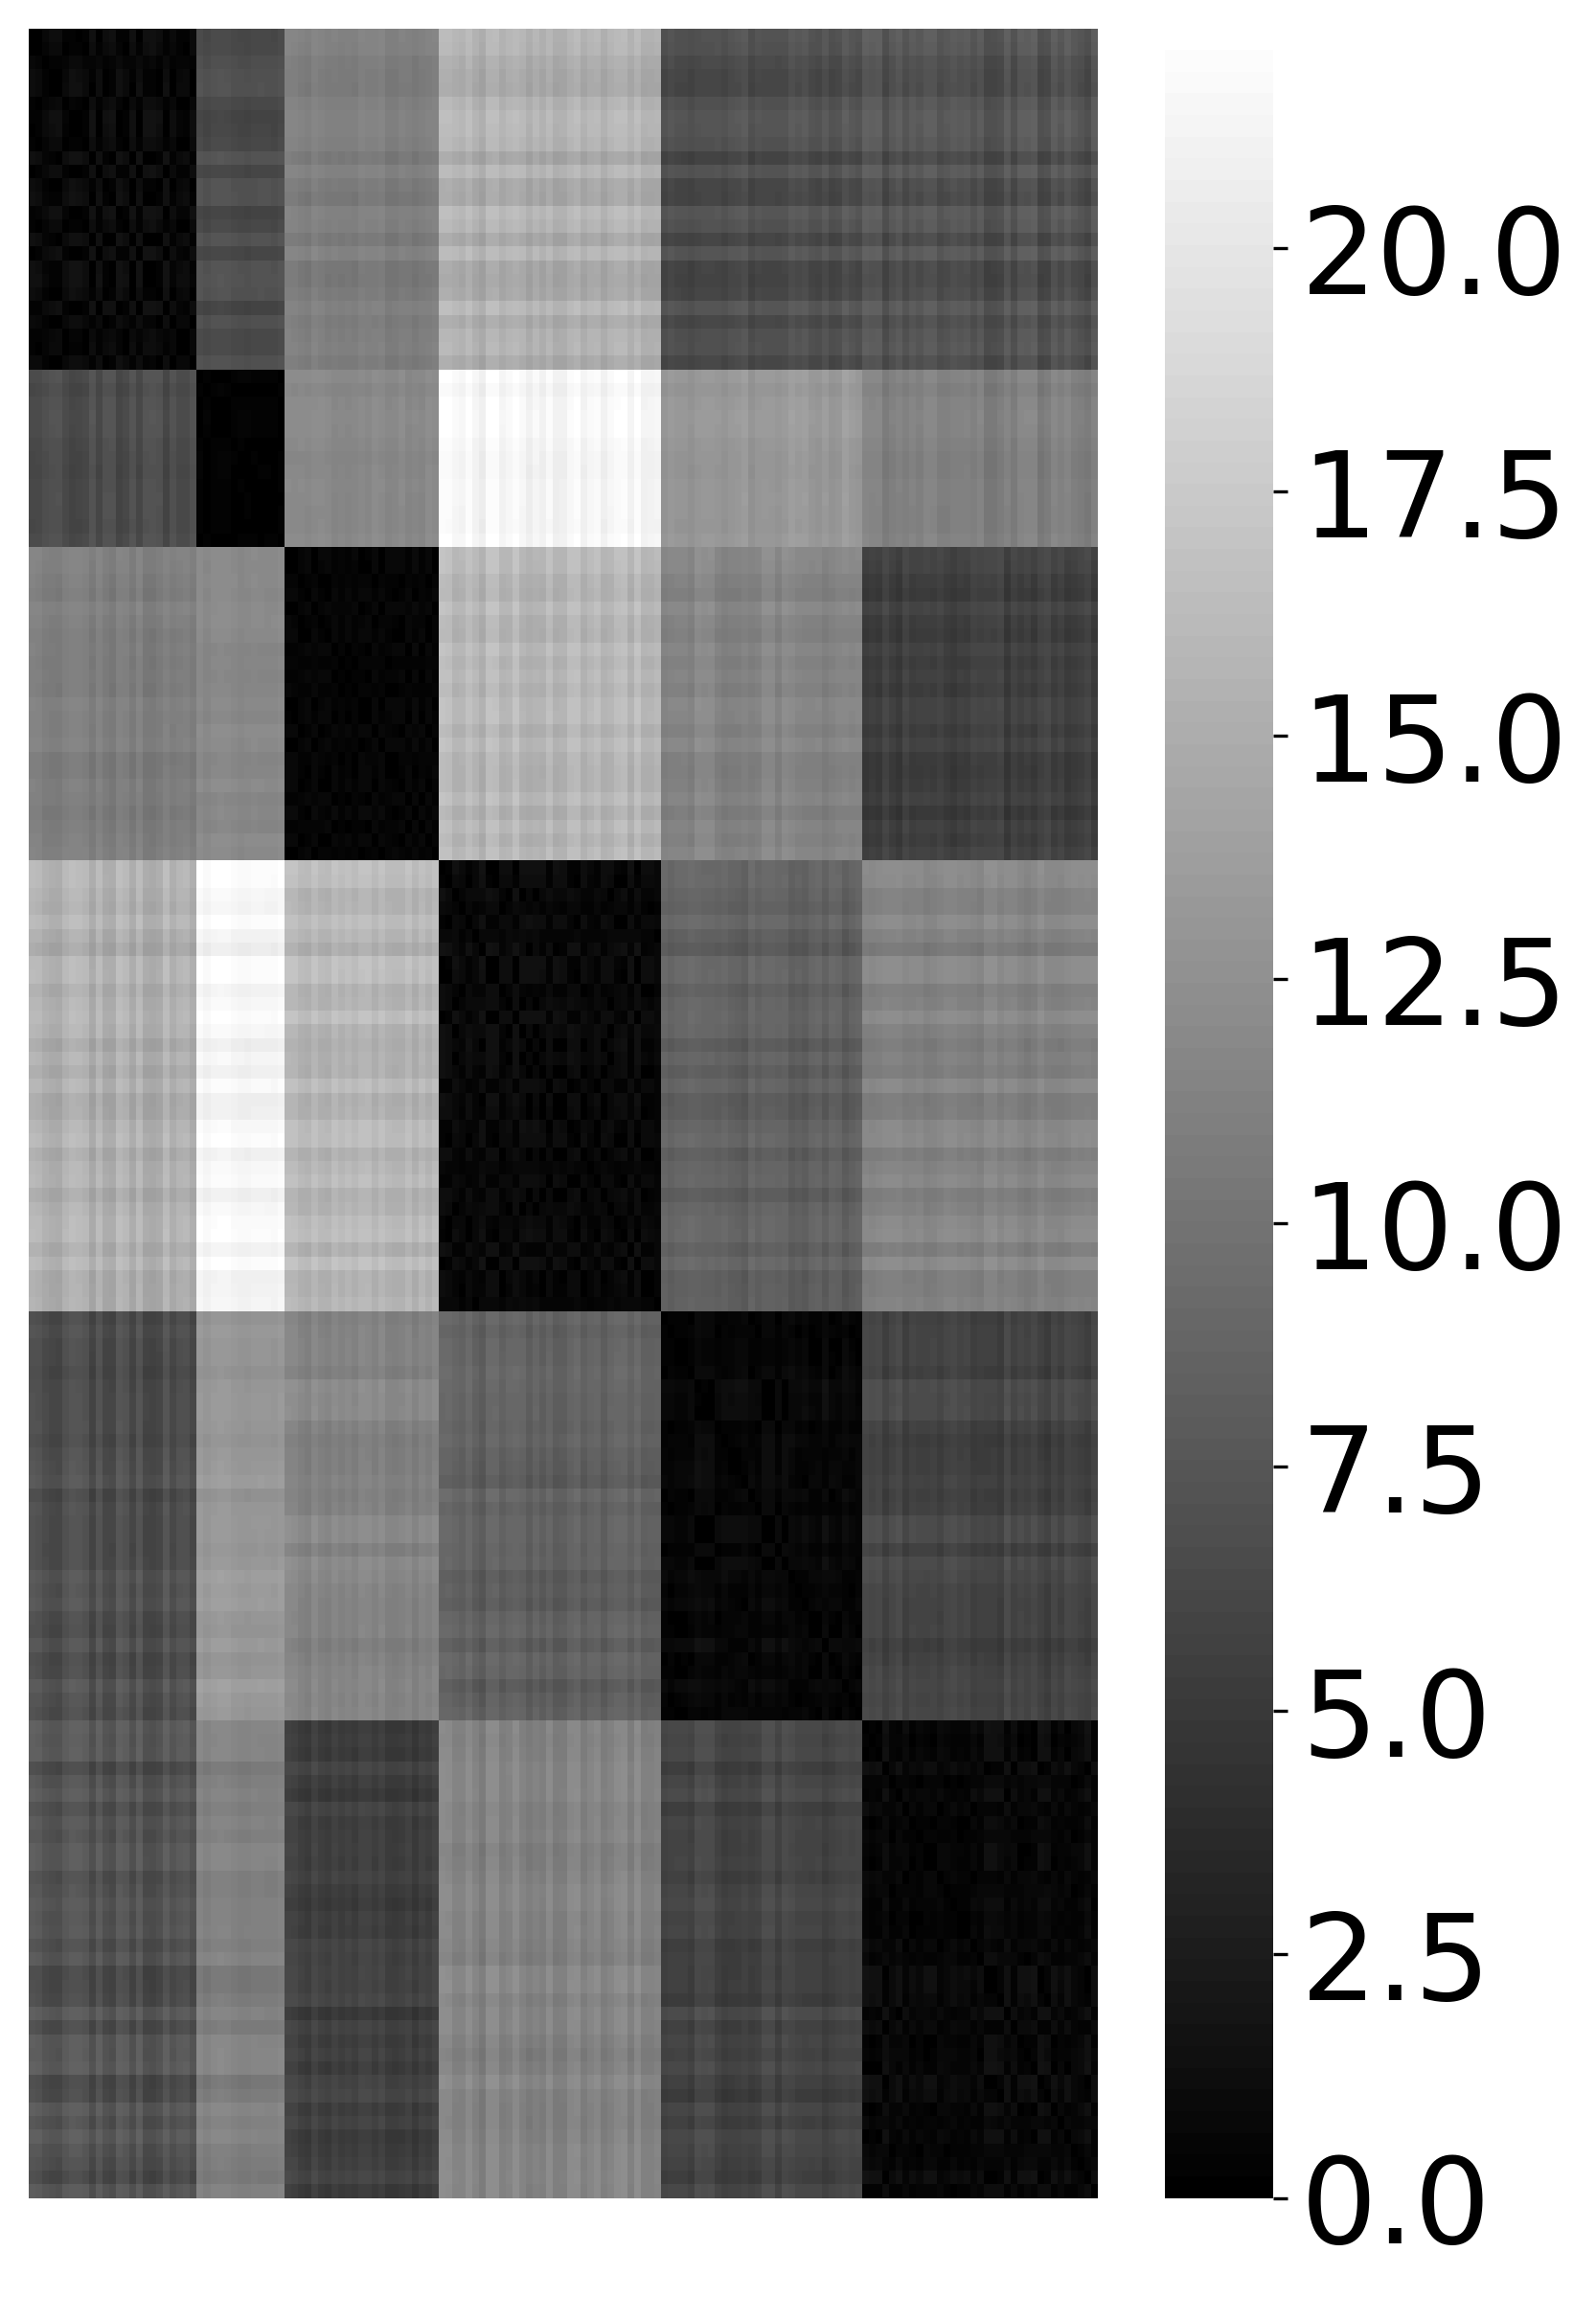

In [26]:
plt.figure(figsize=(6,10),dpi=300)
# plt.title('RDM of Explicit task (59 participants and 159 relationships)')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
mycolor = ['black','grey','white']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)

dissim_umap_rdm = euclidean_distances(umap_exp_results_159r_all_order[['Dim1','Dim2']])
ax = sns.heatmap(dissim_umap_rdm,xticklabels='',yticklabels='',
            cmap = cmaps,cbar=True)
cbar=ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

## UMAP+HDBSCAN 

In [27]:
resultdf_hdb = pd.DataFrame({'dist':[],'ngbr':[], 'silhouette':[],
                             'clusterCount':[],'min_cluster_size':[],
                             'min_samples':[], 'metric':[]})
n_neighbors_list = [5, 10, 15, 20, 25]
min_dist_list = [0.001, 0.01, 0.1]

best_hdbscan_score = -1
best_hdbscan_params = {}
best_umap_params = {}

In [28]:
for n_neighbors in n_neighbors_list:
    for min_dist in min_dist_list:
        umap_embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist,
                                  n_components=2,metric = 'precomputed',random_state=random_seed).\
                            fit_transform(dissim_ctg_avg_159r_all)
        # change different import parameters
        min_cluster_size_list = [5, 10, 15, 20, 25]
        min_samples_list = [1, 2, 3]
        metric_list = ['euclidean', 'manhattan']

        for min_cluster_size in min_cluster_size_list:
            for min_samples in min_samples_list:
                for metric in metric_list:
                    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                                min_samples=min_samples, metric=metric)
                    cluster_labels = clusterer.fit_predict(umap_embedding)

                    # Calculate the silhouette to evaluate performance.
                    silhouette_avg = silhouette_score(umap_embedding, cluster_labels)
                    resultdf_hdb.append({'dist':min_dist,'ngbr':n_neighbors, 'silhouette':silhouette_avg,
                    'min_cluster_size':min_cluster_size, 'min_samples':min_samples, 'metric':metric},ignore_index=True)
    
                    # Select the parameter configuration with the highest silhouette coefficient.
                    if silhouette_avg > best_hdbscan_score:
                        best_hdbscan_score = silhouette_avg
                        best_hdbscan_params = {'min_cluster_size': min_cluster_size, 
                                               'min_samples': min_samples, 'metric': metric}
                        best_umap_params = {'n_neighbors': n_neighbors, 'min_dist': min_dist}

# Print the optimal parameter configuration.
print("Best UMAP Parameters:")
print(best_umap_params)
print("Best HDBSCAN Parameters:")
print(best_hdbscan_params)
print(f"Best Silhouette Score: {best_hdbscan_score}")

Best UMAP Parameters:
{'n_neighbors': 15, 'min_dist': 0.01}
Best HDBSCAN Parameters:
{'min_cluster_size': 10, 'min_samples': 3, 'metric': 'euclidean'}
Best Silhouette Score: 0.8787859082221985


Set the two important parameters of UMAP: the nearest neighbor parameter to 5, 10, 15, 20, 25, and the minimum distance value to 0.001, 0.01, 0.1. For the three important parameters of HDBSCAN clustering, set min_cluster_size to 5, 10, 15, 20, 25, min_samples to 1, 2, 3, and metric to 'euclidean', 'manhattan'. Ultimately, based on the highest silhouette value recommendation, the nearest neighbor parameter is 15, the minimum distance value is 0.01, min_cluster_size is 10, min_samples is 3, and the metric is euclidean.

### best parameters

In [29]:
umap_exp_159r_all = umap.UMAP(n_neighbors=15, min_dist=0.01, n_components=2,
                      metric = 'precomputed',
                      random_state=random_seed).fit_transform(dissim_ctg_avg_159r_all)
umap_exp_159r_all = pd.DataFrame(umap_exp_159r_all, columns=['Dim1','Dim2'], index=dissim_ctg_avg_159r_all.index)

hdb_model =  hdbscan.HDBSCAN(min_cluster_size=10,min_samples=3,metric='euclidean')
cluster_labels = hdb_model.fit_predict(umap_exp_159r_all)

hdb_results = umap_exp_159r_all.copy()
hdb_results['size'] = cluster_labels
cluster_results(result_df=hdb_results, method_number='size')


Cluster 1 Relationship:13
a person and their crush, a person and their deceased spouse, wife and husband, romantic lovers, friends with benefits, bride and groom, life partners, soul mates, fiance and fiancee, long distance lovers, a person and their significant other, man and his mistress, sugar daddy and sugar baby

Cluster 2 Relationship:33
neighbors, friends, teammates in sports, brothers in arms, co workers, bride and bridesmaid, alumni, classmates, church members, roommates, victim and witness, close friends, confidants, playmates, fraternity brothers, a person and their family friends, groom and groomsman, strangers, business partners, peers, cohabitants, pen friends, casual acquaintances, diplomats, facebook friends, companions, criminal and their accomplice, religious followers, childhood friends, a person and their social media follower, sorority sisters, political allies, fans of the same sports team

Cluster 3 Relationship:13
opposing negotiators, man wife and man mistress

Based on this optimal configuration, the clustering result of HDBSCAN is 7, distinguishing 12 relationships with stronger conflict from the original 25 Hostile relationships.

### fine-tune parameters

In [30]:
hdb_model =  hdbscan.HDBSCAN(min_cluster_size=12)
cluster_labels = hdb_model.fit_predict(umap_exp_159r_all)

hdb_results = umap_exp_159r_all.copy()
hdb_results['size'] = cluster_labels
cluster_results(result_df=hdb_results, method_number='size')


Cluster 1 Relationship:33
neighbors, friends, teammates in sports, brothers in arms, co workers, bride and bridesmaid, alumni, classmates, church members, roommates, victim and witness, close friends, confidants, playmates, fraternity brothers, a person and their family friends, groom and groomsman, strangers, business partners, peers, cohabitants, pen friends, casual acquaintances, diplomats, facebook friends, companions, criminal and their accomplice, religious followers, childhood friends, a person and their social media follower, sorority sisters, political allies, fans of the same sports team

Cluster 2 Relationship:13
a person and their crush, a person and their deceased spouse, wife and husband, romantic lovers, friends with benefits, bride and groom, life partners, soul mates, fiance and fiancee, long distance lovers, a person and their significant other, man and his mistress, sugar daddy and sugar baby

Cluster 3 Relationship:25
opposing negotiators, man wife and man mistress

In [34]:
hdb_results['c6'] = hdb_results['size'].map({0:'Affiliative',1:'Romantic',2:'Hostile',
                                        3:'Transactional',4:'Familial',5:'Power'})

In [40]:
umap_exp_results_159r_all = pd.read_csv('../output_data/group/category/cluster_results/umap_exp_results_159r_all_20230920.csv',
                                       index_col=0)
umap_exp_results_159r_all['c6'] = umap_exp_results_159r_all['cl_k6'].map({2:'Affiliative',5:'Romantic',3:'Hostile',
                                        0:'Transactional',4:'Familial',1:'Power'})
c6_results = pd.DataFrame(umap_exp_results_159r_all.iloc[:,-1])
c6_results.to_csv('../output_data/group/category/cluster_results/umap_exp_results_159r_all_6c.csv')

In [36]:
def Jaccard_index(set1,set2):
    union_num = len(set(set1) | set(set2))
    intersect_num = len(set(set1) & set(set2))
    return intersect_num / union_num

In [42]:
for cluster in c6_results.c6.unique():
    c6_cluster = c6_results.index[c6_results.c6==cluster]
    test_cluster = hdb_results.index[hdb_results.c6==cluster]
    print(Jaccard_index(c6_cluster,test_cluster))

1.0
1.0
1.0
1.0
1.0
1.0


If min_cluster_size is changed to 12, the result is the same as that of KMeans.

# Implicit task(M1)

## t-sne: perplexity

In [43]:
resultdf_tsne = pd.DataFrame({'perplex':[], 'clusterCount':[], 'silhouette':[]})
for perplex in range(5,55,5):
    df_subset = TSNE(n_components=2, perplexity=perplex, random_state=random_seed).\
                fit_transform(dissim_mla_avg_159r_all)
    for k in range(2,8):
        model = KMeans(k, random_state=random_seed)
        model.fit(df_subset)
        cluster_labels = model.fit_predict(df_subset)
        silhouette_avg = silhouette_score(df_subset, cluster_labels)

        resultdf_tsne = resultdf_tsne.append({'perplex':perplex,'clusterCount':k,
                         'silhouette':silhouette_avg},ignore_index=True)  

## minimum distance&nearest neighbor

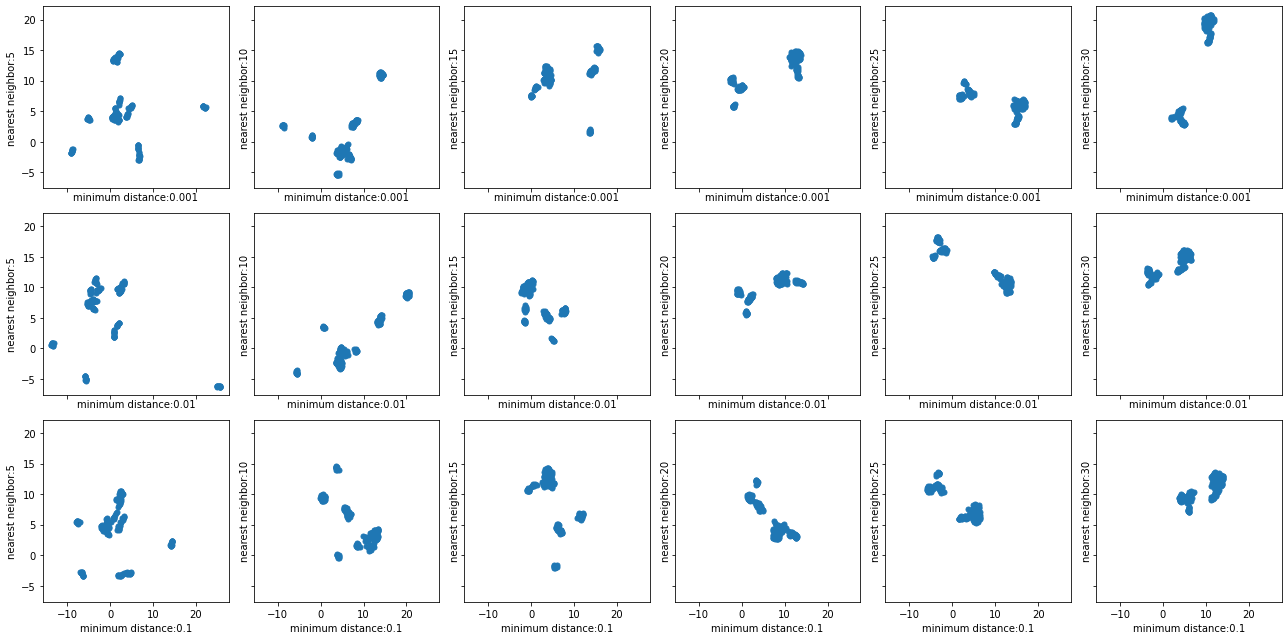

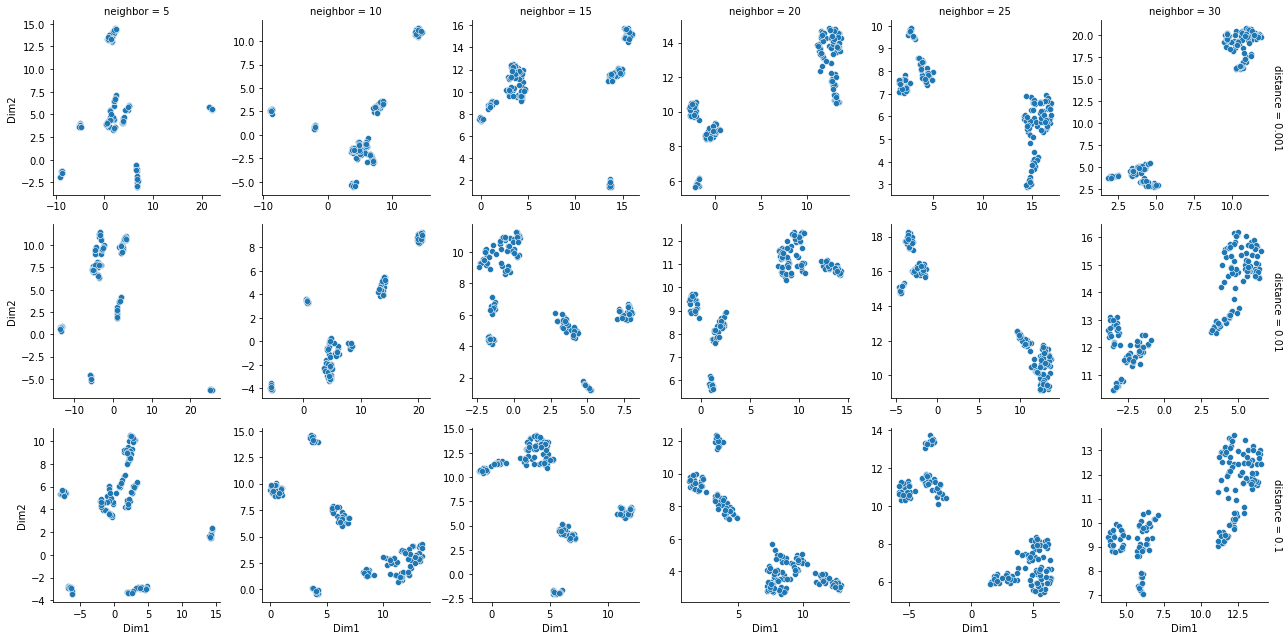

In [7]:
mla_umaps_results = neigh_dist(dissim = dissim_mla_avg_159r_all)
g = sns.FacetGrid(mla_umaps_results, row='distance', col='neighbor',
                  margin_titles=True, sharex=False, sharey=False)
g.map(sns.scatterplot, 'Dim1', 'Dim2')

In [35]:
# resultdf = pd.DataFrame({'dist':[],'ngbr':[], 'clusterCount':[], 'silhouette':[]})
# for dist in [0.001, 0.01,0.1]:
#     for ngbr in [5,10,15,20,25,30]:
#         df_subset = mla_umaps_results[(mla_umaps_results['distance']==dist) & \
#                                       (mla_umaps_results['neighbor']==ngbr)].iloc[:,:2]
#         for k in range(2,8):
#             model = KMeans(k, random_state=random_seed)
#             model.fit(df_subset)
#             cluster_labels = model.fit_predict(df_subset)
#             silhouette_avg = silhouette_score(df_subset, cluster_labels)
            
#             resultdf = resultdf.append({'dist':dist,'ngbr':ngbr,'clusterCount':k,
#                              'silhouette':silhouette_avg},ignore_index=True)  
            
# plt.figure(figsize = (8,5),dpi=150)
# top_5_indices = resultdf['silhouette'].nlargest(5).index
# sns.lineplot(data=resultdf, x='clusterCount', y='silhouette',hue='dist',style='ngbr',palette="deep")
# sns.lineplot(data=resultdf_tsne, x='clusterCount', y='silhouette',linewidth = 3,color="grey")
# max_idx = resultdf['silhouette'].idxmax()
# plt.plot(resultdf.loc[top_5_indices[0], 'clusterCount'], resultdf.loc[top_5_indices[0], 'silhouette'], 
#          marker='o', color='red')
# plt.plot(resultdf.loc[top_5_indices[1], 'clusterCount'], resultdf.loc[top_5_indices[1], 'silhouette'], 
#          marker='o', color='red')
# plt.plot(resultdf.loc[top_5_indices[2], 'clusterCount'], resultdf.loc[top_5_indices[2], 'silhouette'], 
#          marker='o', color='red')
# plt.plot(resultdf.loc[top_5_indices[3], 'clusterCount'], resultdf.loc[top_5_indices[3], 'silhouette'], 
#          marker='o', color='red')
# plt.plot(resultdf.loc[top_5_indices[4], 'clusterCount'], resultdf.loc[top_5_indices[4], 'silhouette'], 
#          marker='o', color='red')
# plt.legend(loc='lower right')

# resultdf.groupby('clusterCount').mean()

<AxesSubplot:xlabel='clusterCount', ylabel='silhouette'>

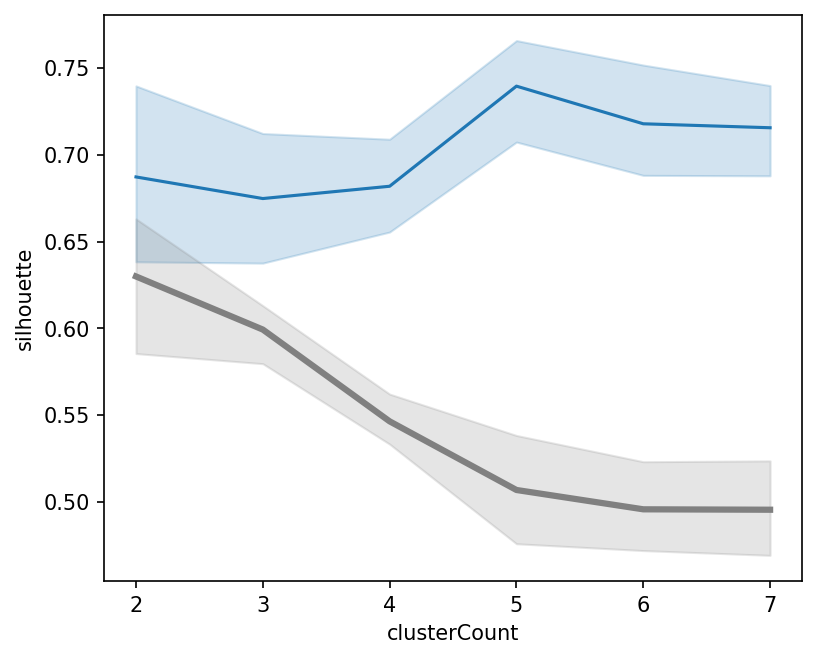

In [44]:
dists = [0.001, 0.01,0.1]
neighbors = [5,10,15,20]
dissim = dissim_mla_avg_159r_all
### 1.UMAP results
umaps_results = pd.DataFrame(columns=['neighbor','distance','Dim1','Dim2'])
for n in neighbors:
    for d in dists:
        temp_umap = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2,
                              random_state=random_seed,metric='precomputed').fit_transform(dissim)
        temp_umap = pd.DataFrame(temp_umap, columns=['Dim1','Dim2'])
        temp_umap['neighbor'] = n
        temp_umap['distance'] = d
        umaps_results = umaps_results.append(temp_umap, sort=True,ignore_index=True)
        
mla_umaps_results = umaps_results       
resultdf = pd.DataFrame({'dist':[],'ngbr':[], 'clusterCount':[], 'silhouette':[]})
for dist in dists:
    for ngbr in neighbors:
        df_subset = mla_umaps_results[(mla_umaps_results['distance']==dist) & \
                                      (mla_umaps_results['neighbor']==ngbr)].iloc[:,:2]
        for k in range(2,8):
            model = KMeans(k, random_state=random_seed)
            model.fit(df_subset)
            cluster_labels = model.fit_predict(df_subset)
            silhouette_avg = silhouette_score(df_subset, cluster_labels)
            
            resultdf = resultdf.append({'dist':dist,'ngbr':ngbr,'clusterCount':k,
                             'silhouette':silhouette_avg},ignore_index=True) 
            
plt.figure(figsize = (6,5),dpi=150)
sns.lineplot(data=resultdf, x='clusterCount', y='silhouette')
sns.lineplot(data=resultdf_tsne, x='clusterCount', y='silhouette',linewidth = 3,color="grey")

In [37]:
resultdf.groupby('clusterCount').mean()

,dist,ngbr,silhouette
clusterCount,,,
2.0,0.037,12.5,0.687283
3.0,0.037,12.5,0.674823
4.0,0.037,12.5,0.681908
5.0,0.037,12.5,0.739626
6.0,0.037,12.5,0.717923
7.0,0.037,12.5,0.715640


## UMAP+KMeans

### data driven: optimal parameters

In [47]:
umap_imp_159r_all = umap.UMAP(n_neighbors=5, min_dist=0.001, n_components=2,
                              metric = 'precomputed',
                      random_state=random_seed).fit_transform(dissim_mla_avg_159r_all)
umap_imp_159r_all = pd.DataFrame(umap_imp_159r_all, columns=['Dim1','Dim2'], index=dissim_mla_avg_159r_all.index)

#clustering.silhouette_cluster(umap_imp_159r_all, *[3,4,5,6])

In [48]:
umap_imp_results_159r_all = clustering.create_cluster_models(data_type = "df",data =umap_imp_159r_all,
                                                  methods= ['KMeans', 'Hierarchical'],ks= [2]+ klist, keep_orig=True)
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k2')


Cluster 1 Relationship:146
nurse and patient, officer and soldier, neighbors, athletic trainer and trainee, police officer and offender, principal and teacher, doctor and nurse, victim and criminal, coach and athlete, man and god, half siblings, parent and teenager, prostitute and customer, church members, foreman and laborer, a person and their family friends, a person and their social media follower, guide and tourist, bride and bridesmaid, teammates in sports, twins, celebrity and haters, employer and employee, teacher and student, guest and host, man wife and man mistress, religious followers, intern and employee, criminal and police officer, step grandparent and step grandchild, chef and customer, union leader and union member, professor and graduate student, second cousins, fans of the same sports team, master and servant, siblings, landlord and housekeeper, close friends, entrepreneur and investor, fraternity brothers, psychologist and client, chief and deputy, uncle and niece/

In [49]:
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k3')


Cluster 1 Relationship:29
neighbors, church members, bride and bridesmaid, teammates in sports, religious followers, fans of the same sports team, close friends, fraternity brothers, childhood friends, confidants, peers, groom and groomsman, brothers in arms, playmates, roommates, friends, political allies, criminal and their accomplice, diplomats, pen friends, casual acquaintances, cohabitants, alumni, co workers, facebook friends, companions, sorority sisters, classmates, business partners

Cluster 2 Relationship:117
nurse and patient, officer and soldier, athletic trainer and trainee, police officer and offender, principal and teacher, doctor and nurse, victim and criminal, coach and athlete, man and god, half siblings, parent and teenager, prostitute and customer, foreman and laborer, a person and their family friends, a person and their social media follower, guide and tourist, twins, celebrity and haters, employer and employee, teacher and student, guest and host, man wife and m

In [50]:
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k5')


Cluster 1 Relationship:25
half siblings, parent and teenager, a person and their family friends, twins, step grandparent and step grandchild, second cousins, siblings, uncle and niece/nephew, step siblings, grandparent and grandchild, brother and sister, parent and infant, ancestor and descendant, adoptive parents and adopted kids, close relatives, godparent and godchild, step parent and step child, babysitter and infant, distant relatives, a person and their in laws, cousins, mother and infant, aunt and niece/nephew, parent and child, foster parent and foster child

Cluster 2 Relationship:66
nurse and patient, officer and soldier, athletic trainer and trainee, principal and teacher, doctor and nurse, coach and athlete, man and god, prostitute and customer, foreman and laborer, a person and their social media follower, guide and tourist, employer and employee, teacher and student, guest and host, intern and employee, chef and customer, union leader and union member, professor and grad

In [51]:
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k6')


Cluster 1 Relationship:25
half siblings, parent and teenager, a person and their family friends, twins, step grandparent and step grandchild, second cousins, siblings, uncle and niece/nephew, step siblings, grandparent and grandchild, brother and sister, parent and infant, ancestor and descendant, adoptive parents and adopted kids, close relatives, godparent and godchild, step parent and step child, babysitter and infant, distant relatives, a person and their in laws, cousins, mother and infant, aunt and niece/nephew, parent and child, foster parent and foster child

Cluster 2 Relationship:66
nurse and patient, officer and soldier, athletic trainer and trainee, principal and teacher, doctor and nurse, coach and athlete, man and god, prostitute and customer, foreman and laborer, a person and their social media follower, guide and tourist, employer and employee, teacher and student, guest and host, intern and employee, chef and customer, union leader and union member, professor and grad

In [52]:
umap_imp_159r_all = umap.UMAP(n_neighbors=15, min_dist=0.001, n_components=2,
                              metric = 'precomputed',
                      random_state=random_seed).fit_transform(dissim_mla_avg_159r_all)
umap_imp_159r_all = pd.DataFrame(umap_imp_159r_all, columns=['Dim1','Dim2'], index=dissim_mla_avg_159r_all.index)

In [53]:
umap_imp_results_159r_all = clustering.create_cluster_models(data_type = "df",data =umap_imp_159r_all,
                                                  methods= ['KMeans', 'Hierarchical'],ks=  klist, keep_orig=True)

clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k3')


Cluster 1 Relationship:54
neighbors, half siblings, parent and teenager, church members, a person and their family friends, bride and bridesmaid, teammates in sports, twins, religious followers, step grandparent and step grandchild, second cousins, fans of the same sports team, siblings, close friends, fraternity brothers, uncle and niece/nephew, childhood friends, step siblings, confidants, grandparent and grandchild, brother and sister, parent and infant, ancestor and descendant, peers, groom and groomsman, adoptive parents and adopted kids, brothers in arms, playmates, roommates, friends, political allies, criminal and their accomplice, diplomats, close relatives, godparent and godchild, pen friends, casual acquaintances, step parent and step child, cohabitants, alumni, babysitter and infant, co workers, distant relatives, a person and their in laws, facebook friends, cousins, mother and infant, companions, aunt and niece/nephew, parent and child, sorority sisters, classmates, fost

### n_neighbors=15, min_dist=0.01

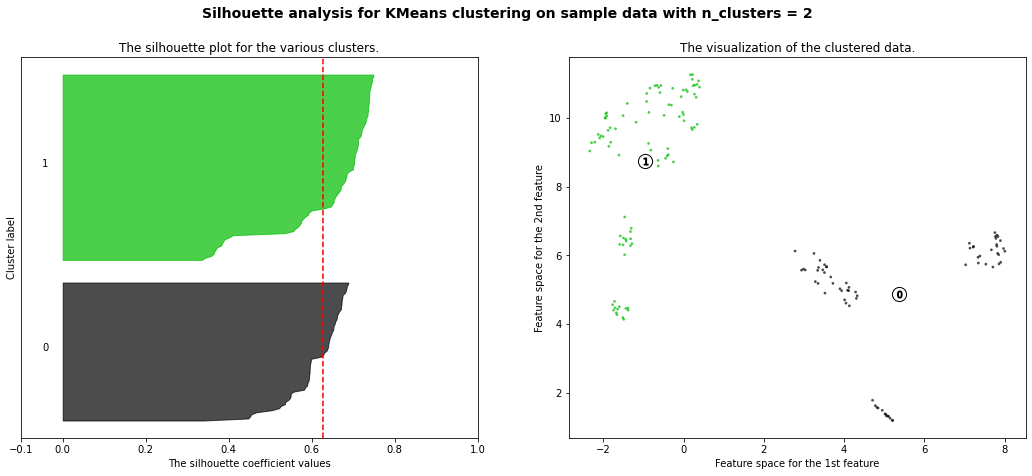

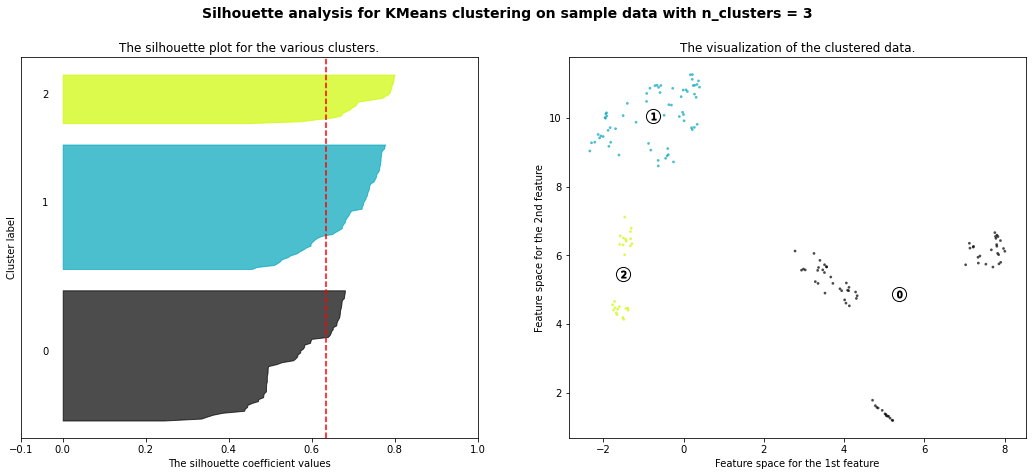

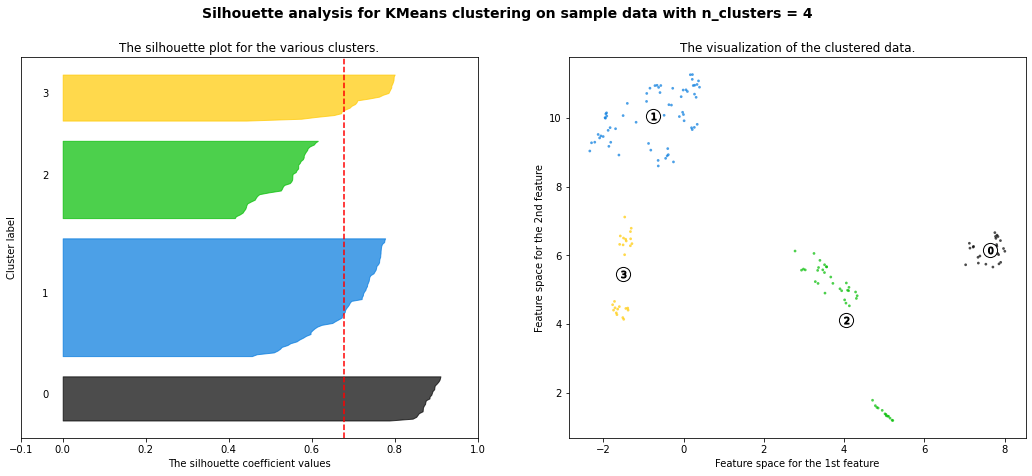

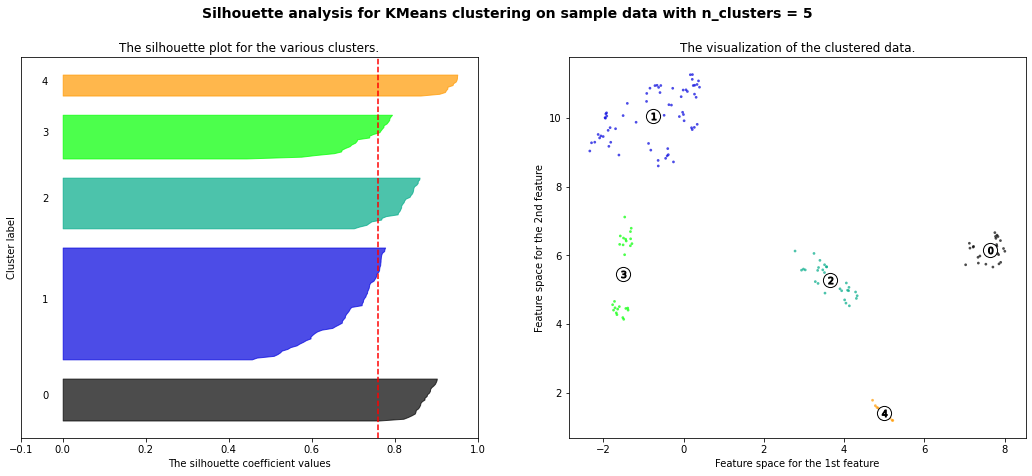

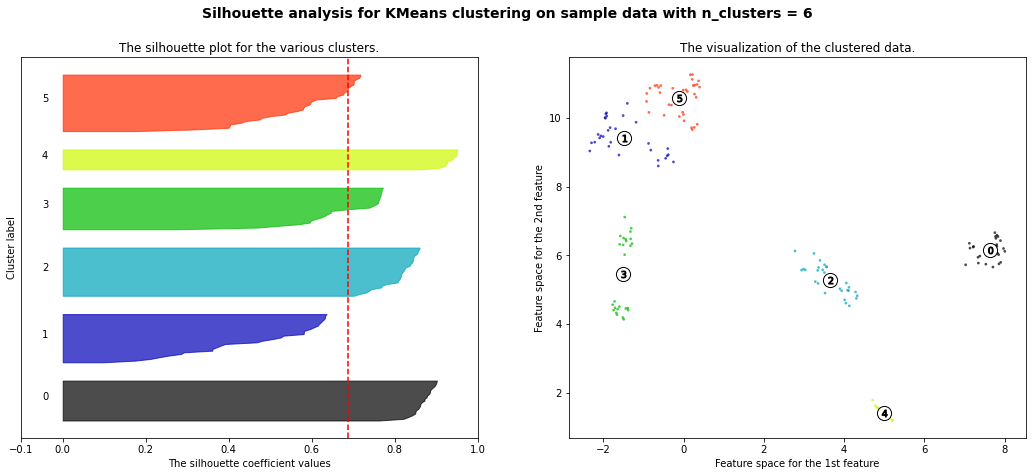

In [72]:
umap_imp_159r_all = umap.UMAP(n_neighbors=15, min_dist=0.01, n_components=2,
                              metric = 'precomputed',
                      random_state=random_seed).fit_transform(dissim_mla_avg_159r_all)
umap_imp_159r_all = pd.DataFrame(umap_imp_159r_all, columns=['Dim1','Dim2'], index=dissim_mla_avg_159r_all.index)
clustering.silhouette_cluster(umap_imp_159r_all, *[2,3,4,5,6])

In [73]:
umap_imp_results_159r_all = clustering.create_cluster_models(data_type = "df",data =umap_imp_159r_all,
                                                  methods= ['KMeans', 'Hierarchical'],ks=  [2]+klist, keep_orig=True)
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k2')


Cluster 1 Relationship:68
wife and husband, neighbors, half siblings, parent and teenager, church members, a person and their family friends, bride and bridesmaid, teammates in sports, twins, religious followers, step grandparent and step grandchild, second cousins, fans of the same sports team, siblings, close friends, fraternity brothers, sugar daddy and sugar baby, uncle and niece/nephew, childhood friends, man and his mistress, step siblings, confidants, grandparent and grandchild, romantic lovers, brother and sister, parent and infant, ancestor and descendant, peers, groom and groomsman, adoptive parents and adopted kids, a person and their significant other, strangers, a person and their crush, brothers in arms, playmates, roommates, friends, life partners, political allies, criminal and their accomplice, diplomats, close relatives, godparent and godchild, pen friends, casual acquaintances, step parent and step child, cohabitants, soul mates, long distance lovers, alumni, babysi

In [74]:
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k3')


Cluster 1 Relationship:68
wife and husband, neighbors, half siblings, parent and teenager, church members, a person and their family friends, bride and bridesmaid, teammates in sports, twins, religious followers, step grandparent and step grandchild, second cousins, fans of the same sports team, siblings, close friends, fraternity brothers, sugar daddy and sugar baby, uncle and niece/nephew, childhood friends, man and his mistress, step siblings, confidants, grandparent and grandchild, romantic lovers, brother and sister, parent and infant, ancestor and descendant, peers, groom and groomsman, adoptive parents and adopted kids, a person and their significant other, strangers, a person and their crush, brothers in arms, playmates, roommates, friends, life partners, political allies, criminal and their accomplice, diplomats, close relatives, godparent and godchild, pen friends, casual acquaintances, step parent and step child, cohabitants, soul mates, long distance lovers, alumni, babysi

Cluster1: Private(68)     
Cluster2: Public(65)       
Cluster3: Hostile(26)   

In [75]:
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k4')


Cluster 1 Relationship:25
half siblings, parent and teenager, a person and their family friends, twins, step grandparent and step grandchild, second cousins, siblings, uncle and niece/nephew, step siblings, grandparent and grandchild, brother and sister, parent and infant, ancestor and descendant, adoptive parents and adopted kids, close relatives, godparent and godchild, step parent and step child, babysitter and infant, distant relatives, a person and their in laws, cousins, mother and infant, aunt and niece/nephew, parent and child, foster parent and foster child

Cluster 2 Relationship:65
nurse and patient, officer and soldier, athletic trainer and trainee, principal and teacher, doctor and nurse, coach and athlete, man and god, prostitute and customer, foreman and laborer, a person and their social media follower, guide and tourist, employer and employee, teacher and student, guest and host, intern and employee, chef and customer, union leader and union member, professor and grad

In [76]:
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k5')


Cluster 1 Relationship:25
half siblings, parent and teenager, a person and their family friends, twins, step grandparent and step grandchild, second cousins, siblings, uncle and niece/nephew, step siblings, grandparent and grandchild, brother and sister, parent and infant, ancestor and descendant, adoptive parents and adopted kids, close relatives, godparent and godchild, step parent and step child, babysitter and infant, distant relatives, a person and their in laws, cousins, mother and infant, aunt and niece/nephew, parent and child, foster parent and foster child

Cluster 2 Relationship:65
nurse and patient, officer and soldier, athletic trainer and trainee, principal and teacher, doctor and nurse, coach and athlete, man and god, prostitute and customer, foreman and laborer, a person and their social media follower, guide and tourist, employer and employee, teacher and student, guest and host, intern and employee, chef and customer, union leader and union member, professor and grad

In [77]:
clustering.cluster_results(umap_imp_results_159r_all,method_number='cl_k6')


Cluster 1 Relationship:25
half siblings, parent and teenager, a person and their family friends, twins, step grandparent and step grandchild, second cousins, siblings, uncle and niece/nephew, step siblings, grandparent and grandchild, brother and sister, parent and infant, ancestor and descendant, adoptive parents and adopted kids, close relatives, godparent and godchild, step parent and step child, babysitter and infant, distant relatives, a person and their in laws, cousins, mother and infant, aunt and niece/nephew, parent and child, foster parent and foster child

Cluster 2 Relationship:30
nurse and patient, athletic trainer and trainee, doctor and nurse, prostitute and customer, a person and their social media follower, guide and tourist, guest and host, chef and customer, entrepreneur and investor, psychologist and client, judge and contestant, therapist and patient, reader and writer, representative and citizen, driver and passenger, television host and guest, consultant and cli

In [78]:
rels_c6_df = umap_imp_results_159r_all.copy()
rels_c6_df['c6'] = rels_c6_df['cl_k6'].map({3:'Hostile',4:'Romantic',0:'Familial',
                                           2:'Affiliative',1:'Transactional',5:'Power'})

In [79]:
for cluster in c6_results.c6.unique():
    print(cluster)
    c6_cluster = c6_results.index[c6_results.c6==cluster]
    test_cluster = rels_c6_df.index[rels_c6_df.c6==cluster]
    print(Jaccard_index(c6_cluster,test_cluster))

Hostile
0.9615384615384616
Transactional
0.7647058823529411
Familial
0.92
Romantic
1.0
Power
0.8421052631578947
Affiliative
0.9090909090909091


<table><tr><td bgcolor="green"><font size=5>output</font></td></tr></table>

In [80]:
umap_imp_results_159r_all.to_csv('../output_data/group/category/cluster_results/umap_imp_results_159r_all.csv')

## UMAP+HDBSCAN 

In [41]:
resultdf_hdb = pd.DataFrame({'dist':[],'ngbr':[], 'silhouette':[],
                             'clusterCount':[],'min_cluster_size':[],
                             'min_samples':[], 'metric':[]})
n_neighbors_list = [5, 10, 15, 20]
min_dist_list = [0.001, 0.01, 0.1]

best_hdbscan_score = -1
best_hdbscan_params = {}
best_umap_params = {}

for n_neighbors in n_neighbors_list:
    for min_dist in min_dist_list:
        umap_embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist,
                                  n_components=2,metric = 'precomputed',random_state=random_seed).\
                            fit_transform(dissim_mla_avg_159r_all)
        # change different import parameters
        min_cluster_size_list = [5, 10, 15, 20]
        min_samples_list = [1, 2, 3]
        metric_list = ['euclidean', 'manhattan']

        for min_cluster_size in min_cluster_size_list:
            for min_samples in min_samples_list:
                for metric in metric_list:
                    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                                min_samples=min_samples, metric=metric)
                    cluster_labels = clusterer.fit_predict(umap_embedding)

                    # Calculate the silhouette to evaluate performance.
                    silhouette_avg = silhouette_score(umap_embedding, cluster_labels)
                    resultdf_hdb = resultdf_hdb.append({'dist':min_dist,'ngbr':n_neighbors, 'silhouette':silhouette_avg,
                    'min_cluster_size':min_cluster_size, 'min_samples':min_samples, 'metric':metric},ignore_index=True)
    
                    # Select the parameter configuration with the highest silhouette coefficient.
                    if silhouette_avg > best_hdbscan_score:
                        best_hdbscan_score = silhouette_avg
                        best_hdbscan_params = {'min_cluster_size': min_cluster_size, 
                                               'min_samples': min_samples, 'metric': metric}
                        best_umap_params = {'n_neighbors': n_neighbors, 'min_dist': min_dist}

# Print the optimal parameter configuration.
print("Best UMAP Parameters:")
print(best_umap_params)
print("Best HDBSCAN Parameters:")
print(best_hdbscan_params)
print(f"Best Silhouette Score: {best_hdbscan_score}")

Best UMAP Parameters:
{'n_neighbors': 20, 'min_dist': 0.001}
Best HDBSCAN Parameters:
{'min_cluster_size': 5, 'min_samples': 3, 'metric': 'manhattan'}
Best Silhouette Score: 0.8281671404838562


In [42]:
resultdf_hdb

,dist,ngbr,silhouette,clusterCount,min_cluster_size,min_samples,metric
0,0.001,5.0,0.665893,NaN,5.0,1.0,euclidean
1,0.001,5.0,0.630084,NaN,5.0,1.0,manhattan
2,0.001,5.0,0.672674,NaN,5.0,2.0,euclidean
3,0.001,5.0,0.667786,NaN,5.0,2.0,manhattan
4,0.001,5.0,0.677817,NaN,5.0,3.0,euclidean
...,...,...,...,...,...,...,...
283,0.100,20.0,0.630591,NaN,20.0,1.0,manhattan
284,0.100,20.0,0.689963,NaN,20.0,2.0,euclidean
285,0.100,20.0,0.611145,NaN,20.0,2.0,manhattan
286,0.100,20.0,0.689963,NaN,20.0,3.0,euclidean


### best parameters

In [140]:
umap_imp_159r_all = umap.UMAP(n_neighbors=20, min_dist=0.001, n_components=2,
                      metric = 'precomputed',
                      random_state=random_seed).fit_transform(dissim_mla_avg_159r_all)
umap_imp_159r_all = pd.DataFrame(umap_imp_159r_all, columns=['Dim1','Dim2'], index=dissim_mla_avg_159r_all.index)

hdb_model =  hdbscan.HDBSCAN(min_cluster_size=5,min_samples=3,metric='manhattan')
cluster_labels = hdb_model.fit_predict(umap_imp_159r_all)

hdb_results = umap_imp_159r_all.copy()
hdb_results['size'] = cluster_labels
cluster_results(result_df=hdb_results, method_number='size')


Cluster 1 Relationship:92
nurse and patient, officer and soldier, athletic trainer and trainee, police officer and offender, principal and teacher, doctor and nurse, victim and criminal, coach and athlete, man and god, prostitute and customer, foreman and laborer, a person and their social media follower, guide and tourist, celebrity and haters, employer and employee, teacher and student, guest and host, man wife and man mistress, intern and employee, criminal and police officer, chef and customer, union leader and union member, professor and graduate student, master and servant, landlord and housekeeper, entrepreneur and investor, psychologist and client, chief and deputy, ex lovers, parole officer and parolee, judge and contestant, researcher and research subject, therapist and patient, slave and master, reader and writer, representative and citizen, criminal and hostage, opposing negotiators, driver and passenger, romantic rivals, strangers, predecessor and successor, volunteer and

### fine-tune parameters

In [20]:
umap_imp_159r_all = umap.UMAP(n_neighbors=20, min_dist=0.01, n_components=2,
                              metric = 'precomputed',
                      random_state=random_seed).fit_transform(dissim_mla_avg_159r_all)
umap_imp_159r_all = pd.DataFrame(umap_imp_159r_all, columns=['Dim1','Dim2'], index=dissim_mla_avg_159r_all.index)

hdb_model =  hdbscan.HDBSCAN(min_cluster_size=13,min_samples=2,metric='euclidean')
cluster_labels = hdb_model.fit_predict(umap_imp_159r_all)

hdb_results = umap_imp_159r_all.copy()
hdb_results['size'] = cluster_labels
cluster_results(result_df=hdb_results, method_number='size')


Cluster 1 Relationship:26
police officer and offender, victim and criminal, celebrity and haters, man wife and man mistress, criminal and police officer, master and servant, ex lovers, parole officer and parolee, slave and master, criminal and hostage, opposing negotiators, romantic rivals, criminal and prosecutor, bully and victim, guard and prisoner, fans of opposing sports teams, sports rivals, enemies, competitors in sports, frenemies, divorced spouses, defendant and plaintiff, police officer and civilian, political opponents, business rivals, victim and witness

Cluster 2 Relationship:25
half siblings, parent and teenager, a person and their family friends, twins, step grandparent and step grandchild, second cousins, siblings, uncle and niece/nephew, step siblings, grandparent and grandchild, brother and sister, parent and infant, ancestor and descendant, adoptive parents and adopted kids, close relatives, godparent and godchild, step parent and step child, babysitter and infant,

## Heatmap

### static(2022)

In [24]:
umap_imp_results_159r_all = pd.read_csv('../output_data/group/category/cluster_results/umap_imp_results_159r_all.csv',
                                         index_col=0)
umap_imp_results_159r_all.index = umap_imp_results_159r_all.index.map(rels_simple_mapped)

rels_c3_df = pd.DataFrame(umap_imp_results_159r_all['cl_k3'])
rels_c3_df[rels_c3_df['cl_k3'] == 2] = -3 #Hostile
rels_c3_df[rels_c3_df['cl_k3'] == 0] = -2 #Private
rels_c3_df[rels_c3_df['cl_k3'] == 1] = -1 #Public
rels_c3_df = rels_c3_df.sort_values(by='cl_k3')
rels_c3 = list(rels_c3_df.index)
umap_imp_results_159r_all_order = umap_imp_results_159r_all.loc[rels_c3,:]

<AxesSubplot: >

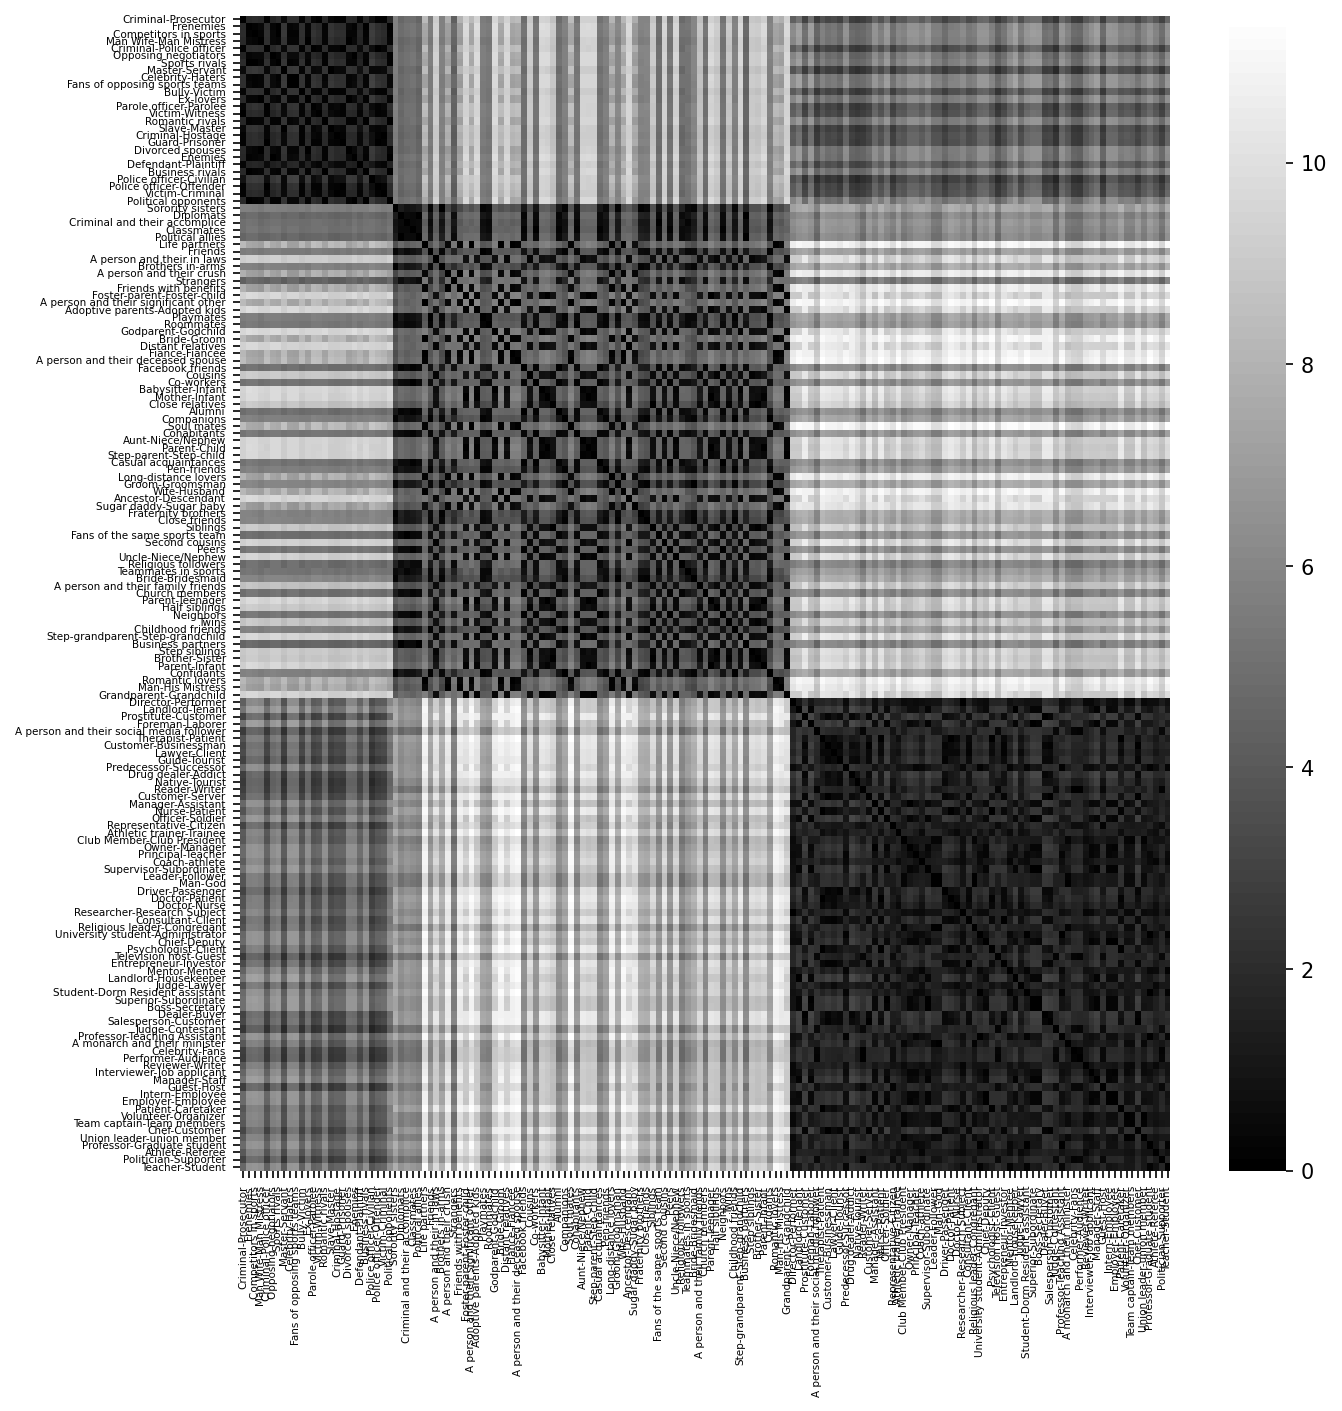

In [25]:
plt.figure(figsize=(10,10),dpi=150)
# plt.title('RDM of Implicit task (59 participants and 159 relationships)')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
mycolor = ['black','grey','white']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
dissim_umap_rdm = euclidean_distances(umap_imp_results_159r_all_order[['Dim1','Dim2']])
sns.heatmap(dissim_umap_rdm,xticklabels=rels_c3,yticklabels=rels_c3,
            cmap = cmaps)

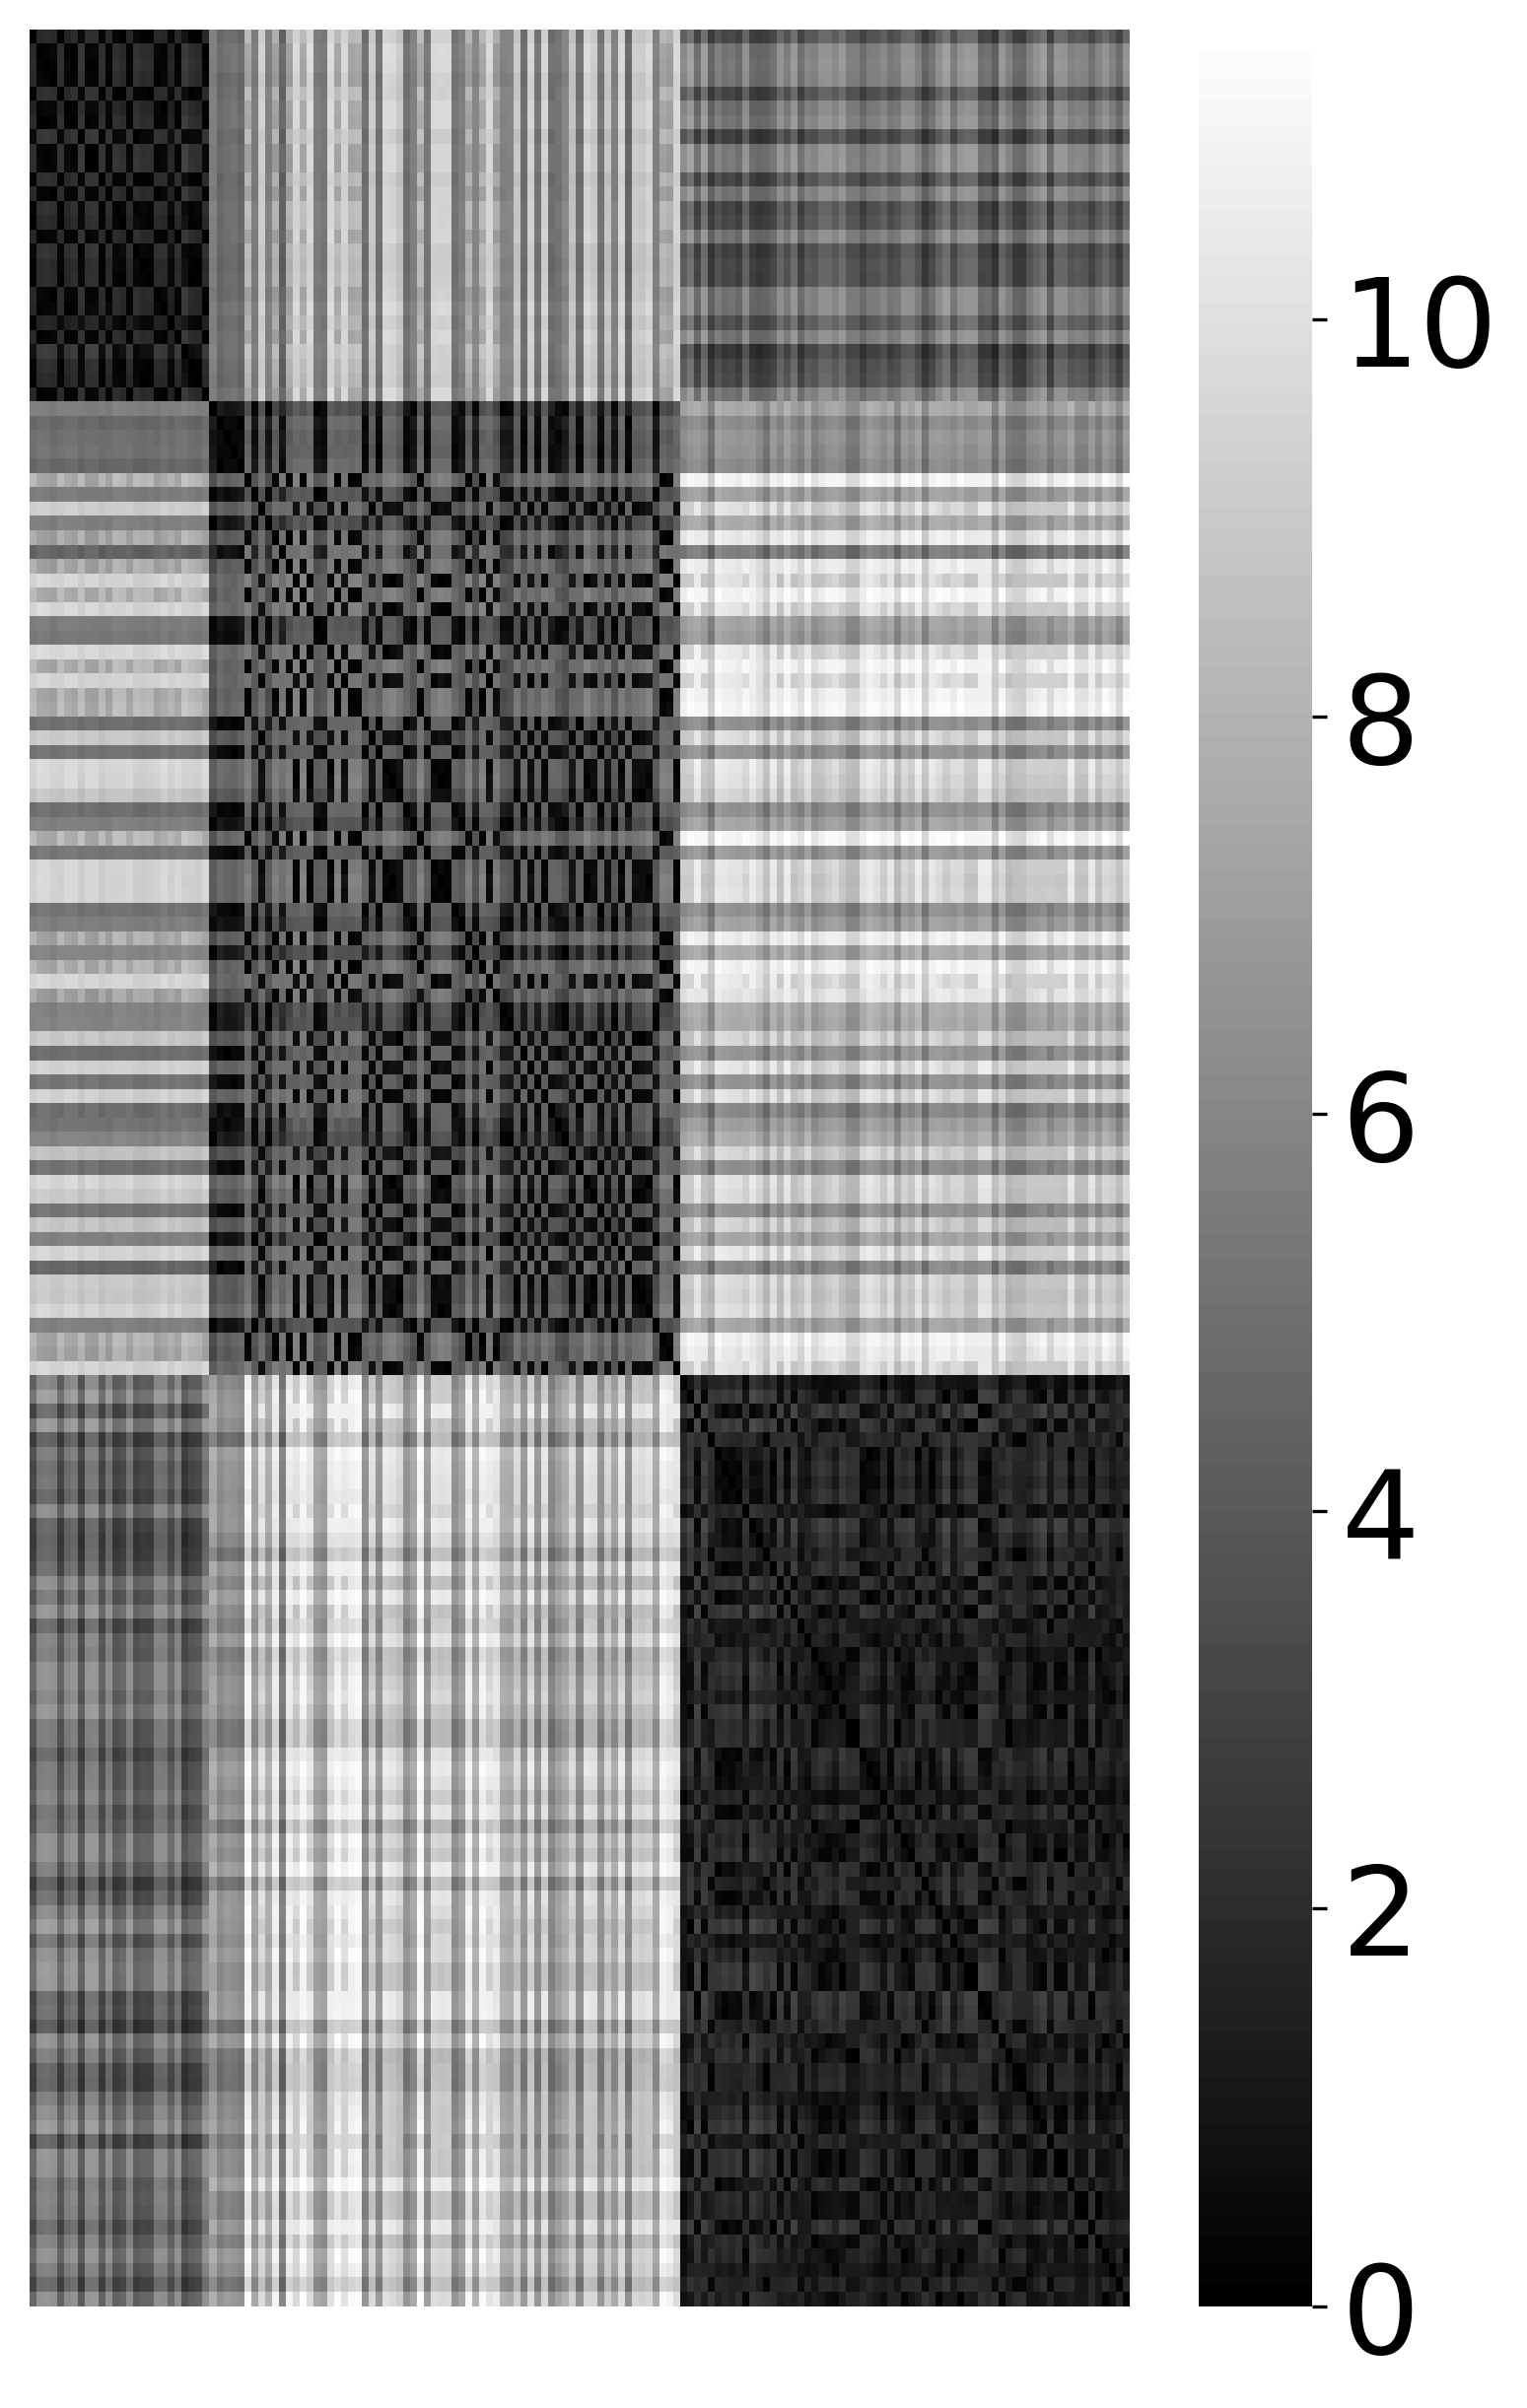

In [17]:
plt.figure(figsize=(6,10),dpi=300)
# plt.title('RDM of Implicit task (59 participants and 159 relationships)')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
dissim_umap_rdm = euclidean_distances(umap_imp_results_159r_all_order[['Dim1','Dim2']])
ax = sns.heatmap(dissim_umap_rdm,xticklabels='',yticklabels='',
            cmap = cmaps,cbar=True)
cbar=ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

### interactive

In [81]:
# dissim_umap_rdm_interact = pd.DataFrame(dissim_umap_rdm,index=rels_c3,columns=rels_c3)
# fig = px.imshow(dissim_umap_rdm_interact,
#                width=450,height=750,aspect='auto',
#                color_continuous_scale=["black", 'white'])
# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)
# fig.update_traces(hovertemplate='%{x}<br>%{y}<br>distance: %{z:.2f}<extra></extra>')
# fig.show()

In [82]:
# plotly.offline.plot(fig,filename='../output_graph/ModelInTasks/Interactive/M1.html')

### static(2023)

In [22]:
umap_imp_results_159r_all=pd.read_csv('../output_data/group/category/cluster_results/umap_imp_results_159r_all.csv',
                                     index_col=0)

<AxesSubplot:>

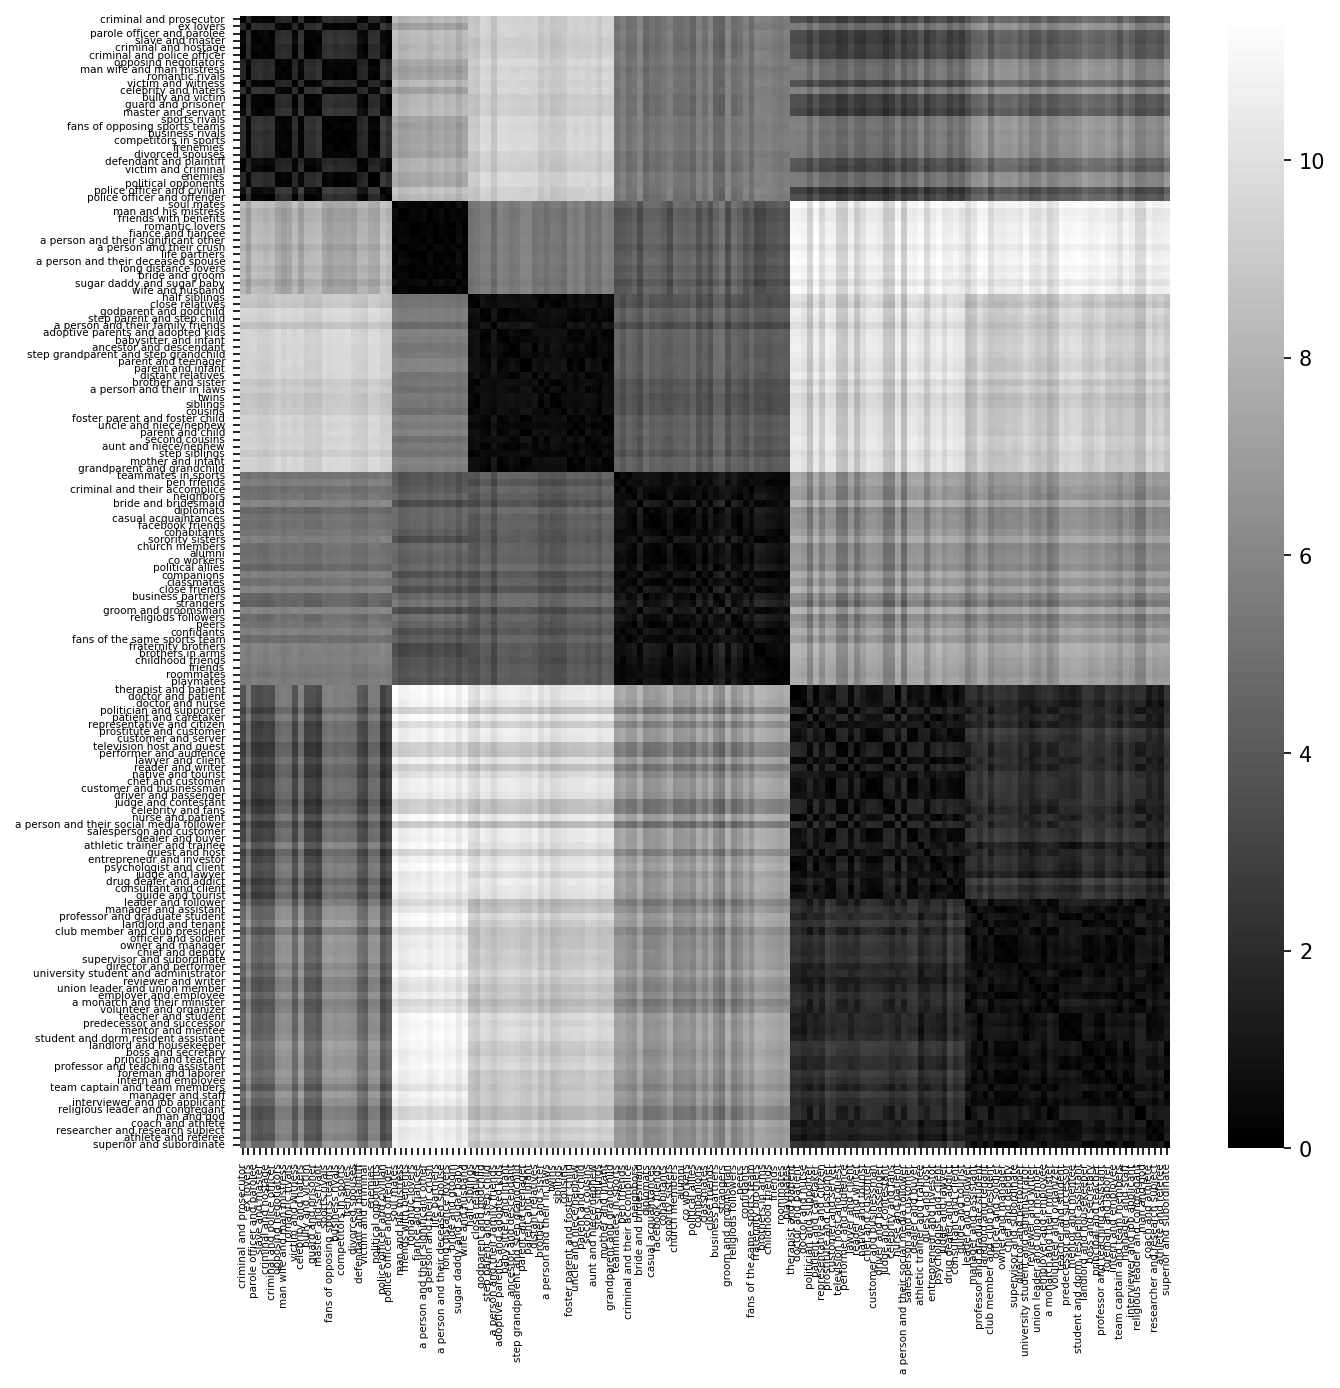

In [23]:
rels_c6_df = pd.DataFrame(umap_imp_results_159r_all['cl_k6'])
rels_c6_df[rels_c6_df['cl_k6'] == 3] = -6#Hostile
rels_c6_df[rels_c6_df['cl_k6'] == 4] = -5#Romantic
rels_c6_df[rels_c6_df['cl_k6'] == 0] = -4#Familial
rels_c6_df[rels_c6_df['cl_k6'] == 2] = -3#Affiliative
rels_c6_df[rels_c6_df['cl_k6'] == 1] = -2#Transactional
rels_c6_df[rels_c6_df['cl_k6'] == 5] = -1#Power
rels_c6_df = rels_c6_df.sort_values(by='cl_k6')
rels_c6 = list(rels_c6_df.index)
umap_imp_results_159r_all_order = umap_imp_results_159r_all.loc[rels_c6,:]

plt.figure(figsize=(10,10),dpi=150)
# plt.title('RDM of Implicit task (59 participants and 159 relationships)')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
mycolor = ['black','grey','white']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
dissim_umap_rdm = euclidean_distances(umap_imp_results_159r_all_order[['Dim1','Dim2']])
sns.heatmap(dissim_umap_rdm,xticklabels=rels_c6,yticklabels=rels_c6,
            cmap = cmaps)

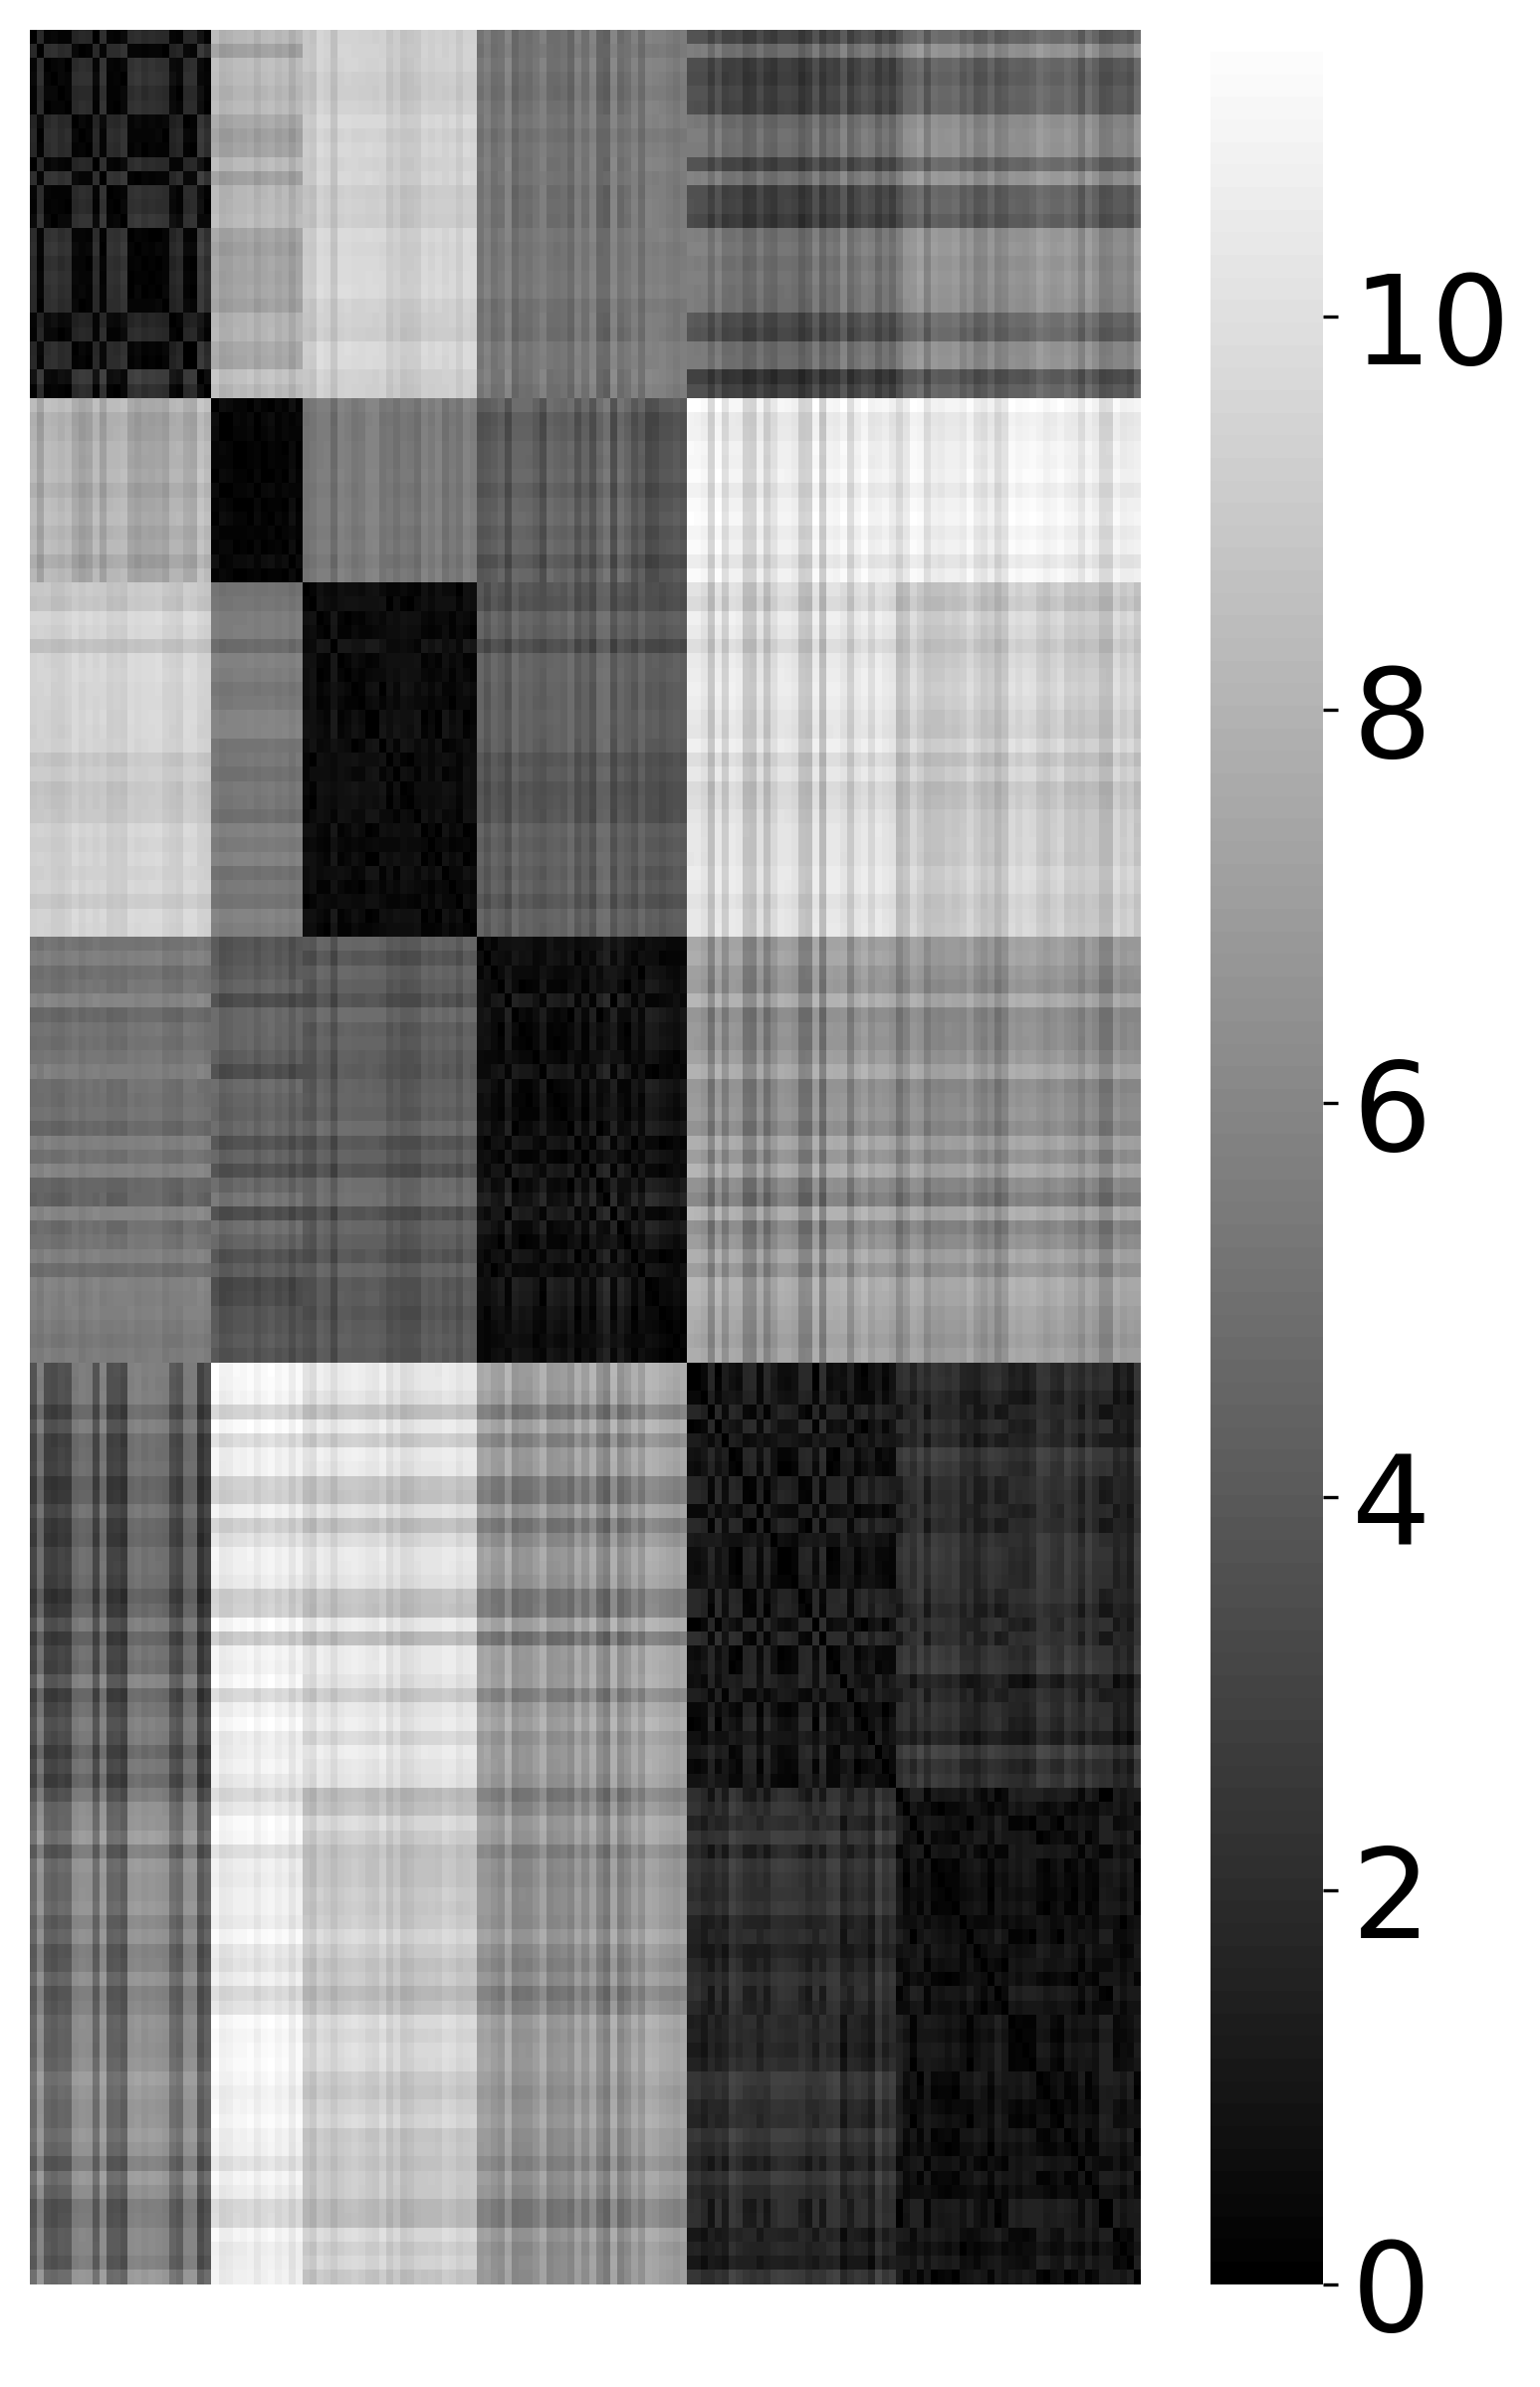

In [24]:
plt.figure(figsize=(6,10),dpi=300)
# plt.title('RDM of Implicit task (59 participants and 159 relationships)')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
dissim_umap_rdm = euclidean_distances(umap_imp_results_159r_all_order[['Dim1','Dim2']])
ax = sns.heatmap(dissim_umap_rdm,xticklabels='',yticklabels='',
            cmap = cmaps,cbar=True)
cbar=ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

# Scatter plot

In [5]:
library(tidyverse)
library(ggplot2)

## Explicit task(M2)

png 
  2

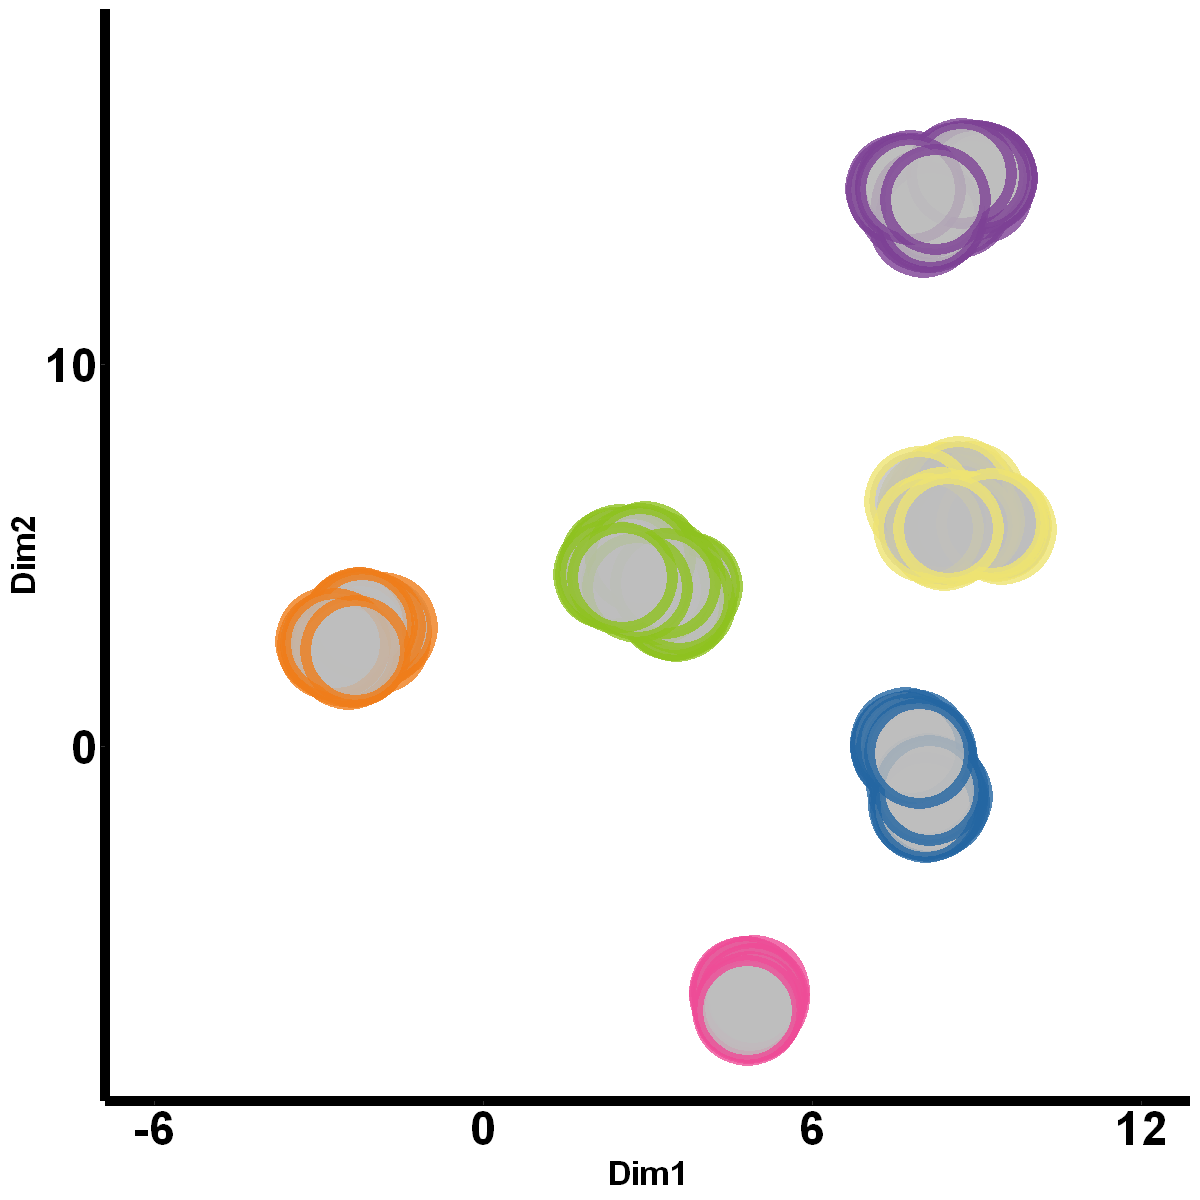

In [36]:
umap_exp_results_159r_all = read.csv('../output_data/group/category/cluster_results/umap_exp_results_159r_all_20230920.csv',
                                     row.names=1)

cluster_plot = umap_exp_results_159r_all %>% select(c('Dim1','Dim2','cl_k6'))
cluster_plot = cluster_plot %>% mutate(cluster = 
                        case_when(cl_k6==1~'Power',
                                  cl_k6==2~'Affiliative',
                                  cl_k6==4~'Familial',
                                  cl_k6==5~'Romantic',
                                  cl_k6==0~'Transactional',
                                  cl_k6==3~'Hostile'))

cluster_color=c('Romantic'='#EE4C97','Familial'='#EF7D1A','Affiliative'='#7D4195',
'Power'='#8EC21F','Hostile'='#2466A2','Transactional'='#EEE372')

options(repr.plot.width=10, repr.plot.height=10)
ggplot(data=cluster_plot,aes(x=Dim1,y=Dim2))+
#geom_point(aes(color=cluster),size=8,stroke=1.2,shape=21)+
geom_point(aes(color=cluster),shape=21,fill='grey',
           size=25,stroke=5,alpha=0.8)+
scale_x_continuous(breaks=seq(-6,12,6),limits = c(-6,12))+
ylim(-8,18)+
scale_color_manual(values=cluster_color)+
theme_bw()+
theme(panel.grid=element_blank(),
      panel.border=element_blank(),
      axis.text=element_text(size=28,face='bold',color='black'),
      axis.title.x=element_text(size=20,face='bold'),
      axis.title.y=element_text(size=20,face='bold'),
      axis.line=element_line(size=3),
      legend.position = 'none',
      legend.key.size = unit(1.2,'cm'),
      legend.text = element_text(size = 25),
      legend.title = element_blank())


#############
png("../output_graph/ModelInTasks/Scatter_M2_revise.png", bg="transparent",
    family = 'sans',units='in',width=10,height=10,res=300)
ggplot(data=cluster_plot,aes(x=Dim1,y=Dim2))+
#geom_point(aes(color=cluster),size=8,stroke=1.2,shape=21)+
geom_point(aes(color=cluster),shape=21,fill='grey',
           size=25,stroke=5,alpha=0.8)+
scale_x_continuous(breaks=seq(-6,12,6),limits = c(-6,12))+
ylim(-8,18)+
scale_color_manual(values=cluster_color)+
theme_bw()+
theme(panel.grid=element_blank(),
      panel.border=element_blank(),
      axis.text=element_blank(),
      axis.title=element_blank(),
      axis.line=element_line(size=3),
      legend.position = 'none',
      legend.key.size = unit(1.2,'cm'),
      legend.text = element_text(size = 25),
      legend.title = element_blank())
dev.off()

## Implicit task(M1)

png 
  2

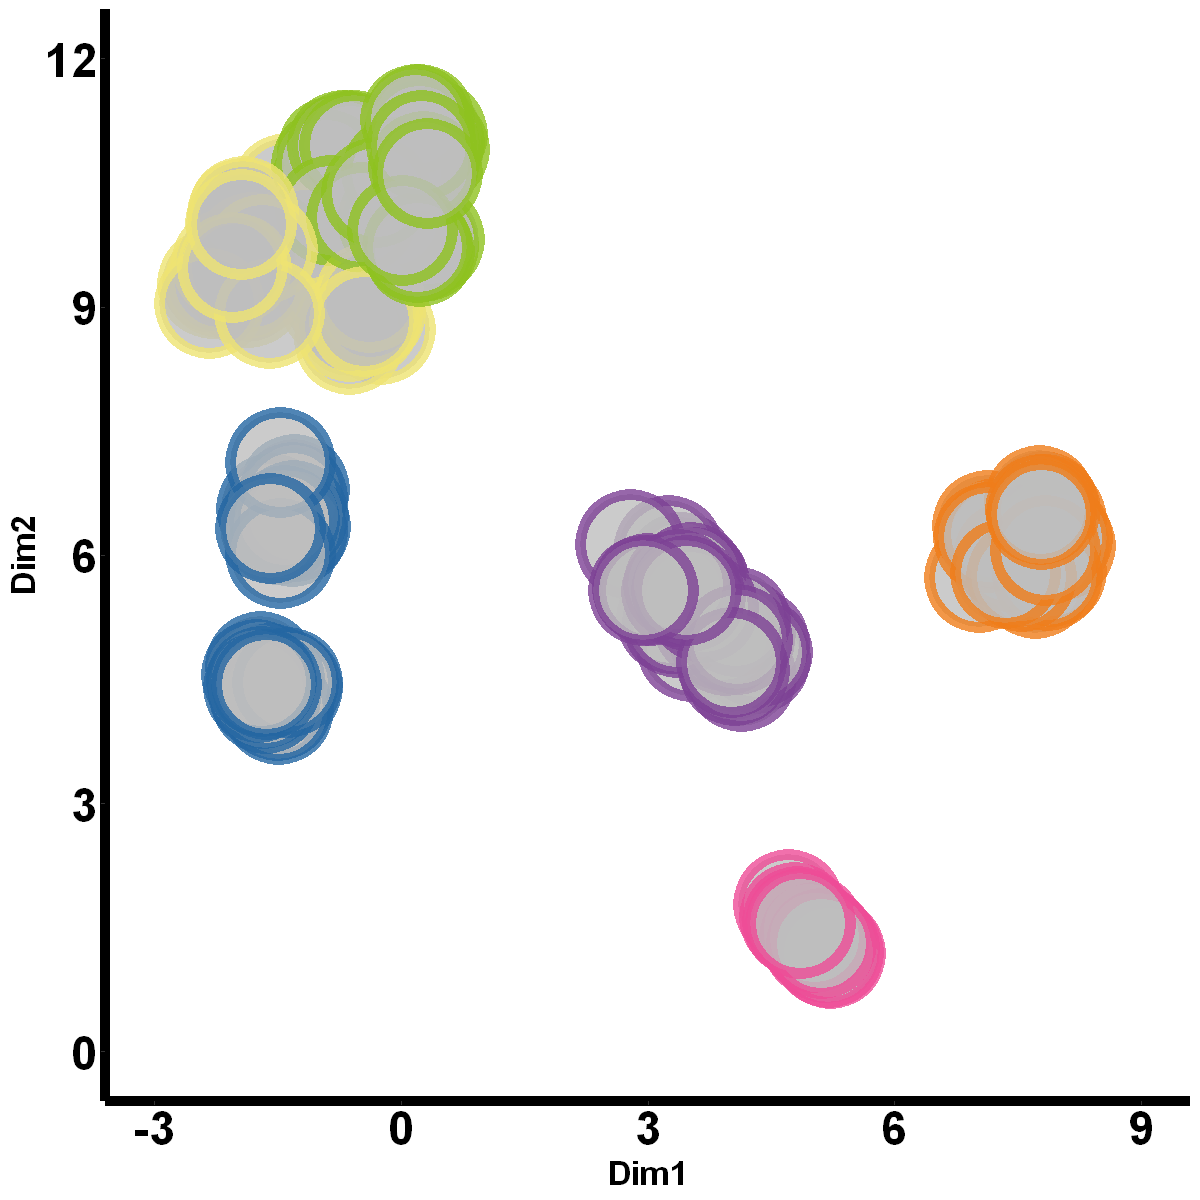

In [34]:
umap_exp_results_159r_all = read.csv('../output_data/group/category/cluster_results/umap_imp_results_159r_all.csv',
                                     row.names=1)

cluster_plot = umap_exp_results_159r_all %>% select(c('Dim1','Dim2','cl_k6'))
cluster_plot = cluster_plot %>% mutate(cluster = 
                        case_when(cl_k6==5~'Power',
                                  cl_k6==2~'Affiliative',
                                  cl_k6==0~'Familial',
                                  cl_k6==4~'Romantic',
                                  cl_k6==1~'Transactional',
                                  cl_k6==3~'Hostile'))

cluster_color=c('Romantic'='#EE4C97','Familial'='#EF7D1A','Affiliative'='#7D4195',
'Power'='#8EC21F','Hostile'='#2466A2','Transactional'='#EEE372')

options(repr.plot.width=10, repr.plot.height=10)
ggplot(data=cluster_plot,aes(x=Dim1,y=Dim2))+
#geom_point(aes(color=cluster),size=8,stroke=1.2,shape=21)+
geom_point(aes(color=cluster),shape=21,fill='grey',
           size=25,stroke=5,alpha=0.8)+
scale_x_continuous(breaks=seq(-3,9,3),limits = c(-3,9))+
scale_y_continuous(breaks=seq(0,12,3),limits = c(0,12))+
scale_color_manual(values=cluster_color)+
theme_bw()+
theme(panel.grid=element_blank(),
      panel.border=element_blank(),
      axis.text=element_text(size=28,face='bold',color='black'),
      axis.title.x=element_text(size=20,face='bold'),
      axis.title.y=element_text(size=20,face='bold'),
      axis.line=element_line(size=3),
      legend.position = 'none',
      legend.key.size = unit(1.2,'cm'),
      legend.text = element_text(size = 25),
      legend.title = element_blank())


#############
png("../output_graph/ModelInTasks/Scatter_M1_revise.png", bg="transparent",
    family = 'sans',units='in',width=10,height=10,res=300)
ggplot(data=cluster_plot,aes(x=Dim1,y=Dim2))+
#geom_point(aes(color=cluster),size=8,stroke=1.2,shape=21)+
geom_point(aes(color=cluster),shape=21,fill='grey',
           size=25,stroke=5,alpha=0.8)+
scale_x_continuous(breaks=seq(-3,9,3),limits = c(-3,9))+
scale_y_continuous(breaks=seq(0,12,3),limits = c(0,12))+
scale_color_manual(values=cluster_color)+
theme_bw()+
theme(panel.grid=element_blank(),
      panel.border=element_blank(),
      axis.text=element_blank(),
      axis.title=element_blank(),
      axis.line=element_line(size=3),
      legend.position = 'none',
      legend.key.size = unit(1.2,'cm'),
      legend.text = element_text(size = 25),
      legend.title = element_blank())
dev.off()